In [7]:
import os
import sys
import boto3
import pandas as pd
import numpy as np
import pickle
from datetime import date, datetime, timedelta
import logging 
sys.path.append('/home/ec2-user/SageMaker/jupyter-notebooks/')
from utils import * 
from category_encoders import OneHotEncoder
import xgboost as xgb
# import lightgbm as lgbm


logger = logging.getLogger()
logging.basicConfig(level=logging.INFO)
s3 = boto3.client('s3') 

# import snowflake-connector-python
import snowflake.connector
import sys
import plotly.graph_objects as go
path=!pwd
sys.path.append('/home/ec2-user/SageMaker/jupyter-notebooks/')

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )
        return ctx
    
from io import StringIO
class Utils():
#     self.env = {'bucket': 'hbo-ingest-datascience-content-dev', 'folder':'psi_firstviews'}
    @staticmethod
    def to_csv_s3(content, filename):
        client = boto3.client('s3')
        bucket = 'hbo-ingest-datascience-content-dev'
        key = os.path.join('psi_first_views/dev', filename)
        csv_buffer = StringIO()
        content.to_csv(csv_buffer)
        client.put_object(Bucket=bucket, Key=key, Body=csv_buffer.getvalue())
        logger.info(f'Saved to {key}')
    
    @staticmethod
    def to_pkl_s3(content, filename):
        client = boto3.client('s3')
        bucket = 'hbo-ingest-datascience-content-dev'
        key = os.path.join('psi_first_views/dev', filename)
        obj = pickle.dumps(content)
        client.put_object(Bucket=bucket, Key=key, Body=obj)
        logger.info(f'Saved model to {os.path.join(bucket, key)}')
        logger.info(f'Saved to {key}')

    @staticmethod
    def read_csv_s3(filename):
        client = boto3.client('s3')
        bucket = 'hbo-ingest-datascience-content-dev'
        key = os.path.join('psi_first_views/dev', filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        df = pd.read_csv(obj['Body'])
        logger.info(f'Read from {key}')
        return df
        
    @staticmethod
    def read_pkl_s3(filename):
        client = boto3.client('s3')
        bucket = 'hbo-ingest-datascience-content-dev'
        key = os.path.join('psi_first_views/dev', filename)
        obj = client.get_object(Bucket=bucket, Key=key)
        body = obj['Body'].read()
        model = pickle.loads(body)
        logger.info(f'Read from {key}')
        return model


In [29]:


class BaseFeatureMunger():
    def __init__(self, df_in, df_imdb_munged, mode, date_run):
        self.df_in = df_in
        self.df_imdb_munged = df_imdb_munged
        self.mode = mode
        self.date_run = date_run
        self.clean_df()
        self.fill_missing_data()
        if mode=='train':
            self.filter_df()
        self.get_datetime_features()
        self.aggregate_df()
        self.merge_imdb_features()
        self.get_first_views()
        self.return_df()
        
    def return_df(self):
        col_base = ['title_id', 'title_name', 'season_number',
       'content_category', 'content_source', 'category',
       'tier', 'effective_start_date', 'request_date', 'first_views',
       'days_since_premiere', 'days_on_platform', 'start_year']
        col_title = ['tier','content_category','category','title_name', 'title_id','season_number',
                'effective_start_date', 'prequel_count', 'prequel_featured_count','first_views','first_views_log']
        if self.mode=='train':
            return self.df_in[col_base], self.df_in_title[col_title]
        elif self.mode=='predict':
            return self.df_in_title[col_title]

    def clean_df(self):
        logger.info(f'base_data shape: {self.df_in.shape}')
#         logger.info(f'base_data null: {self.df_in.isnull().sum()}')
        self.dic_dtype = {'season_number':int, 'tier':int}
        self.df_in = self.df_in.astype(self.dic_dtype)
        self.df_in['effective_start_date'] = pd.to_datetime(self.df_in['effective_start_date'])
        
    def fill_missing_data(self):
        self.df_in['content_category'] = self.df_in['content_category'].fillna('series')
        self.df_in.loc[self.df_in['category'].isin(['Specials']), 'content_category']='special'
        self.df_in.loc[self.df_in['category'].isin(['Popcorn','Pay 1 WB Theatricals','Scripted Features', 'Pay1']), 'content_category']='movies'
        self.df_in.loc[self.df_in['title_name'].str.contains('Harry Potter'), 'content_category']='special'
        self.df_in = self.df_in.fillna(0)

    def filter_df(self):
        self.date_max = datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=60)
        self.df_in = self.df_in[(self.df_in['effective_start_date']<=self.date_max)]

    def get_datetime_features(self):
        self.df_in['start_year'] = self.df_in['effective_start_date'].dt.year
        self.df_in['start_quarter'] = self.df_in['effective_start_date'].dt.quarter
        
    def aggregate_df(self):
        grpby_title= ['title_name', 'title_id','tier','content_category','category','season_number',
                'effective_start_date']
        self.df_in_title = self.df_in[grpby_title + ['first_views']].groupby(by=grpby_title).sum().reset_index()

    def merge_imdb_features(self):
        key_merge = ['title_name','season_number', 'content_category', 'category', 'tier', 'effective_start_date']
        self.df_in_title = self.df_in_title.merge(self.df_imdb_munged, 
                                         on= key_merge, how='left')
        logger.info(f'title imdb shape: {self.df_in_title.shape}')
#         logger.info(f'title imdb features null: {self.df_in_title.isnull().sum()}')
        self.df_in_title = self.df_in_title.fillna(0)
        
    def get_first_views(self):
        ## Scale first_views 
        self.df_in_title['first_views_log'] = np.log(self.df_in_title['first_views']) 
        self.df_in_title.loc[(self.df_in_title.first_views==0), 'first_views_log']=0
        

class IMDBFeatureMunger(BaseFeatureMunger):
    
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in
        self.date_run = date_run 
        
        self.clean_df()
        if mode=='train':
            self.filter_df()
        self.get_series_features()
        if mode=='train':
            self.adjust_series_for_training_data()
        self.get_non_series_prequel_features()
        self.get_non_series_prequel_ref_features()
        self.merge_non_series_features()
        self.return_df()
        
    def return_df(self):
        col_imdb = ['title_name', 'season_number', 'content_category', 'category', 
                    'tier', 'effective_start_date', 'prequel_count', 'prequel_featured_count']
        self.df_imdb_munged = pd.concat([self.df_series_title, self.df_nseries_title])
        self.df_imdb_munged = self.df_imdb_munged[col_imdb]
        return self.df_imdb_munged
    
    def get_series_features(self):
        grpby_series = ['title_name','title_id','season_number','content_category','category','tier','effective_start_date']
        self.df_series = self.df_in[(self.df_in.content_category=='series') & (self.df_in.reference_type.isin(['featured_in']))] 
        self.df_series_title = self.df_series.groupby(by=grpby_series).agg({'reference_title_id':'nunique'}).reset_index()
        self.df_series_title = self.df_series_title.rename(columns={'reference_title_id':'ref_ref_featured_in'})
#         self.df_series_title[['ref_follows','ref_spin_off_from','ref_remake_of']] = 0
        self.df_series_title['prequel_count'] = self.df_series_title['season_number']

    def adjust_series_for_training_data(self):     
        self.df_series_title['ref_ref_featured_in'] = (self.df_series_title['ref_ref_featured_in'] * (self.df_series_title['season_number']-1))/self.df_series_title['season_number']
        self.df_series_title.loc[self.df_series_title.season_number>1, 'prequel_featured_count'] = (self.df_series_title['ref_ref_featured_in'])/(self.df_series_title['season_number']-1)

    def get_non_series_prequel_features(self):
        self.grpby_nseries=['title_name','title_id','season_number','content_category','category','tier','effective_start_date','imdb_imdb_series_id']
        
        self.df_nseries = self.df_in[(self.df_in.content_category!='series')\
                                     & (self.df_in.reference_type.isin(['follows','spin_off_from','remake_of','version_of']))] 
        self.df_nseries_preq = self.df_nseries.groupby(by=self.grpby_nseries+['reference_type']).agg({'reference_title_id':'nunique'}).reset_index()
        self.df_nseries_preq = self.df_nseries_preq.pivot(index=self.grpby_nseries, 
                                                                columns='reference_type', 
                                                                values='reference_title_id').reset_index()
        self.df_nseries_preq = self.df_nseries_preq.rename(columns={'follows':'ref_follows',  
                                                                          'spin_off_from':'ref_spin_off_from', 
                                                                          'remake_of':'ref_remake_of',
                                                                          'version_of':'ref_version_of'})
        
    def get_non_series_prequel_ref_features(self):
        self.df_nseries_preq_ref = self.df_nseries.groupby(by=self.grpby_nseries+['reference_reference_type']).agg({'reference_reference_title_id':'nunique'}).reset_index()
        self.df_nseries_preq_ref = self.df_nseries_preq_ref.pivot(index=self.grpby_nseries, \
                                                                        columns='reference_reference_type', values='reference_reference_title_id').reset_index()
        self.df_nseries_preq_ref = self.df_nseries_preq_ref.rename(columns={'featured_in':'ref_ref_featured_in'})

    def merge_non_series_features(self):
        col_preq = ['title_name', 'tier','season_number','content_category','category','effective_start_date','imdb_imdb_series_id','ref_follows','ref_spin_off_from','ref_remake_of', 'ref_version_of']
        col_ref_ref = ['title_name','season_number','category','ref_ref_featured_in']
        self.df_nseries_title = self.df_nseries_preq[col_preq].merge(self.df_nseries_preq_ref[col_ref_ref], how='outer', on=['title_name','season_number','category'])
        self.df_nseries_title['prequel_count'] = self.df_nseries_title[['ref_follows','ref_spin_off_from','ref_remake_of','ref_version_of']].sum(axis=1)
        self.df_nseries_title['prequel_featured_count'] = self.df_nseries_title['ref_ref_featured_in']/self.df_nseries_title['prequel_count']
        
        
class PreProcessor():
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in
        self.date_run = date_run
        self.get_parameters()
        self.winsorize_features()
        self.adjust_tiers()
        if mode=='train':
            self.winsorize_label()
            self.resample_data()
        self.return_df()
        
    def return_df(self):
        return self.df_in
    
    def get_parameters(self):
        self.max_firstviews = 1000000
        self.old_sampling_rate = 0.4
        self.recent_sampling_rate = 0.6
        self.pay1_sampling_rate = 0.5
    
    def adjust_tiers(self):
        self.df_in['tier_adj'] = self.df_in['tier']
        self.df_in.loc[(self.df_in.title_name=='Reminiscence'), 'tier_adj'] = 2
        self.df_in.loc[(self.df_in.category=='Pay1') & (self.df_in.tier==1), 'tier_adj'] = 2
        self.df_in.loc[(self.df_in.category=='Pay1') & (self.df_in.tier==2), 'tier_adj'] = 3
        self.df_in.loc[(self.df_in.effective_start_date < '2022-04-01') & (self.df_in.category=='Popcorn') & (self.df_in.tier==1), 'tier_adj'] = 0
#         self.df_in.loc[(self.df_in.effective_start_date < '2022-04-01') & (self.df_in.category=='Popcorn') & (self.df_in.tier==2), 'tier_adj'] = 1
        
    def winsorize_label(self):
        self.df_in.loc[self.df_in.first_views>self.max_firstviews, 'first_views'] = self.max_firstviews
    
    def winsorize_features(self):
        ## winsorize season to 10
        ## winsorize ref_tot to 5 
        ## winsorize ref_ref tot to 20
        ## Penalize kids & family 
        ## for series future titles, nullify ref_ features to keep consistent 
        self.df_in.loc[(self.df_in['prequel_count']>5), ['prequel_count']] = 5
        self.df_in.loc[(self.df_in['prequel_featured_count']>20), ['prequel_featured_count']] = 20   
#         self.df_in.loc[(self.df_in.content_category=='series') & (self.df_in['prequel_count']>3), 'prequel_count'] = 3
#         self.df_in.loc[(self.df_in['category']=='Kids & Family'), ['prequel_featured_count']] = -1
        self.df_in.loc[(self.df_in['content_category']=='series'), ['prequel_count']] = -1
        self.df_in.loc[(self.df_in['content_category']=='series'), ['prequel_featured_count']] = -1

    def resample_data(self):  
        self.df_in_old = self.df_in[(self.df_in.effective_start_date < datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=270))]
        self.df_in_recent = self.df_in[(self.df_in.effective_start_date >= datetime.strptime(self.date_run, '%Y-%m-%d')- timedelta(days=270))]
        target_count = self.df_in.groupby(by=['tier_adj','category'])['title_name'].count().max()
        target_count_old = int(round(target_count*self.old_sampling_rate))
        target_count_new = int(round(target_count*self.recent_sampling_rate))
        
        ## Loop through old and recent data
        df_resample_list = []
        for df_sample, target_count in zip([self.df_in_old, self.df_in_recent], [target_count_old, target_count_new]):
            list_tier_cat= df_sample[['tier_adj','category']].drop_duplicates(subset=['tier_adj','category']).values.tolist()
            
            ## Loop through unique combination of tier & category to resample 
            for tier_cat in list_tier_cat:
                if tier_cat[1]=='Pay1':
                    df_resample_list.append(df_sample[(df_sample.tier_adj==tier_cat[0]) & (df_sample.category==tier_cat[1])]\
                                        .sample(int(round(target_count*self.pay1_sampling_rate)), replace=True))                
                else:
                    df_resample_list.append(df_sample[(df_sample.tier_adj==tier_cat[0]) & (df_sample.category==tier_cat[1])]\
                                        .sample(target_count, replace=True))
        self.df_in = pd.concat(df_resample_list, axis=0)

    
class XGB(Utils):
    def __init__(self, df_in, mode, date_run):
        self.df_in = df_in    
        self.mode = mode
        self.date_run = date_run
        self.get_parameters()
        
        if mode=='train':
            self.train_xgb()
            self.save_model()
        elif mode=='predict':
            self.get_model()
            self.predict_xgb()
            self.return_df()
            
    @staticmethod
    def _encode(df, categoricals):
        
        """
        perform category encoding on the data
        :param df: dataframe to be encoded
        :param categoricals: list of name of categorical columns
        :return ohe, x_ohe: OHE object and OHE-encoded data
        """
        ohe = OneHotEncoder(cols=categoricals, 
                            handle_unknown='return_nan',
                           handle_missing='return_nan',  
                           use_cat_names=True) 
        x_ohe = ohe.fit_transform(df)
        return ohe, x_ohe
    
    def return_df(self):
        return self.df_pred
    
    def get_parameters(self):
        self.target = 'first_views_log'
        self.features_cat=['tier_adj','category','content_category',] #
        self.features_cont=['prequel_count', 'prequel_featured_count']
        self.param_xgb = {"booster":"gbtree",
                     "objective":"reg:squarederror",
                    "gamma":1}

    def train_xgb(self):
        x_train = self.df_in[self.features_cat + self.features_cont]
        y_train = self.df_in[self.target]
        self.ohe, x_ohe = self._encode(x_train, self.features_cat)
        dm_train = xgb.DMatrix(x_ohe, label=y_train)

        ## train 
        self.model = xgb.train(params = self.param_xgb, dtrain = dm_train, num_boost_round = 10)
        
    def save_model(self):
        dict_model = {'model': self.model, 'ohe': self.ohe}
        Utils.to_pkl_s3(dict_model, f'fv_{date_train}.pkl')
        logger.info(f'Done model training {date_train}')
    
    def get_model(self):
        dict_model = Utils.read_pkl_s3(f'fv_{date_train}.pkl')
        self.ohe = dict_model['ohe']
        self.model = dict_model['model']
        
    def predict_xgb(self):
        x_test = self.df_in[self.features_cat + self.features_cont]
        x_ohe_test = self.ohe.transform(x_test)
        dm_test = xgb.DMatrix(x_ohe_test)
        pred = self.model.predict(dm_test)

        self.df_pred = self.df_in[list(set(['title_name','category','season_number', 'effective_start_date', 'tier','tier_adj'] + self.features_cat + self.features_cont))]
        self.df_pred['first_views_log_pred'] = pred
        self.df_pred[f'first_views_pred'] = np.exp(self.df_pred[f'first_views_log_pred'])
        self.df_pred['pred_date'] = self.date_run
        self.df_pred['pred_date'] = pd.to_datetime(self.df_pred['pred_date'])
        self.df_pred.loc[(self.df_pred.category=='Popcorn') & (self.df_pred.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'


class FVDecay(Utils):
    def __init__(self, df_in, mode, date_run, grpby=''):
        self.df_in = df_in    
        self.mode = mode
        self.date_run = date_run
        self.grpby = grpby

        if mode=='train':
            self.get_decay_data_title()
            self.get_decay_curve()
            self.save_decay_curve()
            self.return_df()

    def return_df(self):
        return self.df_decay
        
    @staticmethod
    def apply_decay_curve(df_in, df_decay, df_popcorn_decay):
        category_list_train = df_decay.category.unique().tolist()
        df_in['decay_category'] = df_in['category']
        df_in.loc[(~df_in['decay_category'].isin(category_list_train)) & (df_in['decay_category']!='Popcorn'), 'decay_category'] = 'Pay1'
        
        
        ## Apply decay to prediction 
        df_pred_decay = df_in.merge(df_decay[['category','days_since_premiere','first_views_pct']], 
                                                left_on=['decay_category'], right_on=['category'], how='left', suffixes=['', '_category'])\
                            .merge(df_popcorn_decay[['category','days_since_premiere','first_views_pct']], 
                                        on=['category','days_since_premiere'], how='left', suffixes=['', '_popcorn'])
        print(df_pred_decay.columns)
        df_pred_decay.loc[(df_pred_decay.category=='Popcorn') & (df_pred_decay.first_views_pct.isnull()), 'first_views_pct'] = df_pred_decay['first_views_pct_popcorn']
        
        df_pred_decay[f'first_views_pred_decay'] = df_pred_decay[f'first_views_pred'] * df_pred_decay['first_views_pct']
        df_pred_decay['start_month'] = df_pred_decay['effective_start_date'].dt.to_period('M').dt.to_timestamp()
        df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
        df_pred_decay['first_view_quarter'] = df_pred_decay['request_date'].dt.to_period('Q').dt.to_timestamp()
        df_pred_decay['first_view_month'] = df_pred_decay['request_date'].dt.to_period('M').dt.to_timestamp()

        return df_pred_decay
    
    def get_decay_data_title(self):
        self.key_col = ['title_name','tier','content_category','category','season_number','effective_start_date']
        self.df_in = self.df_in[self.key_col + ['title_id','days_since_premiere','first_views']].sort_values(by=self.key_col+['days_since_premiere'])
        self.df_in['first_views_sum'] = self.df_in.groupby(self.key_col)['first_views'].transform('sum')
        self.df_in['first_views_cumsum'] = self.df_in.groupby(by=self.key_col)['first_views'].cumsum()
        self.df_in['first_views_cumpct'] = self.df_in['first_views_cumsum'] / self.df_in['first_views_sum']
        self.df_in.reset_index(inplace=True)
            
    def get_decay_curve(self):
        self.df_decay = self.df_in[[self.grpby] + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=[self.grpby]+['days_since_premiere'])
        self.df_decay = self.df_decay.groupby(by=[self.grpby] + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
        self.df_decay = self.df_decay.rename(columns={'title_id':'title_count_training'})
        self.df_decay = self.df_decay.reset_index()
        self.df_decay['first_views_pct'] = self.df_decay.groupby(self.grpby)['first_views_cumpct'].diff()
        self.df_decay.reset_index(inplace=True)
        
        self.df_decay['days_since_premiere'] = self.df_decay['days_since_premiere'].astype(int)
        self.df_decay.loc[(self.df_decay.days_since_premiere==0),'first_views_pct'] = self.df_decay['first_views_cumpct']
        
    def save_decay_curve(self):
        Utils.to_csv_s3(self.df_decay, f'fv_decay_{self.grpby}_{self.date_run}.csv')

backtest = True 
schedule = 'alpha' 
df_pred_list = []
df_pred_decay_list = [] ##
if backtest==True:
    list_date_train = ['2021-12-01']#['2021-01-01', '2021-02-01', '2021-03-01','2021-04-01', '2021-05-01', '2021-06-01','2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01']
else:
    list_date_train = ['2021-12-01']
    
for date_train in list_date_train:
#     date_pred = '2022-01-13' 
    date_pred=date_train
    logger.info(f'TRAINING MODEL FOR {date_train}, BACKTEST:{backtest}')

    #### Train 
    mode = 'train'
    key_col = ['title_name', 'title_id','tier','content_category','category','season_number','effective_start_date']

    ## Read data 
    df_raw = Utils.read_csv_s3(f'fv_train_{date_train}.csv')
    df_imdb = Utils.read_csv_s3(f'fv_train_imdb_2021-12-01.csv')

    ## Munge features 
    df_imdb_munged = IMDBFeatureMunger(df_imdb, mode, date_train).df_imdb_munged
    df_base_munged_decay, df_base_munged = BaseFeatureMunger(df_raw, df_imdb_munged, mode, date_train).return_df()
    df_decay_category = FVDecay(df_base_munged_decay, mode, date_train, 'category').return_df()

    df_in_train = PreProcessor(df_base_munged, mode, date_train).return_df()  
    XGB(df_in_train, mode, date_train)


    #### Predict 
    mode = 'predict'
    logger.info(f'PREDICTING FOR {date_pred}, backtest:{backtest}')
    
    ## Read data and munge features 
    if backtest:
        df_imdb_pred = Utils.read_csv_s3(f'fv_train_imdb_2021-12-01.csv')
        df_raw_pred = Utils.read_csv_s3(f'fv_train_2021-12-01.csv')
        df_imdb_munged_pred = IMDBFeatureMunger(df_imdb_pred, mode, date_pred).return_df()
        df_base_munged_pred = BaseFeatureMunger(df_raw_pred, df_imdb_munged_pred, mode, date_pred).return_df()
        df_base_munged_pred = df_base_munged_pred[(df_base_munged_pred.effective_start_date >= date_pred)\
                                  & (df_base_munged_pred.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')+ timedelta(days=92))]
    else:
        df_imdb_pred = Utils.read_csv_s3(f'fv_pred_{date_pred}.csv')
        df_raw_pred = df_imdb_pred[df_imdb_pred.schedule_label==schedule][key_col]
        df_raw_pred['first_views'] = 0
        df_imdb_munged_pred = IMDBFeatureMunger(df_imdb_pred, mode, date_pred).return_df()
        df_base_munged_pred = BaseFeatureMunger(df_raw_pred, df_imdb_munged_pred, mode, date_pred).return_df()
        
    df_in_pred = PreProcessor(df_base_munged_pred, mode, date_pred).return_df()  
    ## Predict and apply decay 
    df_out_pred = XGB(df_in_pred, mode, date_pred).return_df()
    df_decay_category = Utils.read_csv_s3(f'fv_decay_category_{date_train}.csv') 
    df_decay_popcorn = Utils.read_csv_s3(f'fv_decay_category_2021-09-01.csv') 
    df_pred_decay = FVDecay.apply_decay_curve(df_out_pred, df_decay_category, df_decay_popcorn)
    
    df_pred_list.append(df_out_pred)
    df_pred_decay_list.append(df_pred_decay)

df_pred = pd.concat(df_pred_list)
df_pred_decay = pd.concat(df_pred_decay_list)


INFO:root:TRAINING MODEL FOR 2021-01-01, BACKTEST:True
INFO:root:Read from psi_first_views/dev/fv_train_2021-01-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (129, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-01-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-01-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-01-01.pkl
INFO:root:Done model training 2021-01-01
INFO:root:PREDICTING FOR 2021-01-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-01-01.pkl

A value is trying to be set on a 

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-02-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (161, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-02-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-02-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-02-01.pkl
INFO:root:Done model training 2021-02-01
INFO:root:PREDICTING FOR 2021-02-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-02-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-03-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (180, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-03-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-03-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-03-01.pkl
INFO:root:Done model training 2021-03-01
INFO:root:PREDICTING FOR 2021-03-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-03-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-04-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (199, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-04-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-04-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-04-01.pkl
INFO:root:Done model training 2021-04-01
INFO:root:PREDICTING FOR 2021-04-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-04-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-05-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (217, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-05-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-05-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-05-01.pkl
INFO:root:Done model training 2021-05-01
INFO:root:PREDICTING FOR 2021-05-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-05-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-06-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (234, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-06-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-06-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-06-01.pkl
INFO:root:Done model training 2021-06-01
INFO:root:PREDICTING FOR 2021-06-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-06-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (34160, 19)
INFO:root:title imdb shape: (250, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-07-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-07-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-07-01.pkl
INFO:root:Done model training 2021-07-01
INFO:root:PREDICTING FOR 2021-07-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-07-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-08-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (265, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-08-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-08-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-08-01.pkl
INFO:root:Done model training 2021-08-01
INFO:root:PREDICTING FOR 2021-08-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-08-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-09-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (282, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-09-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-09-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-09-01.pkl
INFO:root:Done model training 2021-09-01
INFO:root:PREDICTING FOR 2021-09-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-09-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-10-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (302, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-10-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-10-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-10-01.pkl
INFO:root:Done model training 2021-10-01
INFO:root:PREDICTING FOR 2021-10-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-10-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_2021-11-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (317, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-11-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-11-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-11-01.pkl
INFO:root:Done model training 2021-11-01
INFO:root:PREDICTING FOR 2021-11-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-11-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (330, 10)
INFO:root:Saved to psi_first_views/dev/fv_decay_category_2021-12-01.csv
INFO:root:Saved model to hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_2021-12-01.pkl
INFO:root:Saved to psi_first_views/dev/fv_2021-12-01.pkl
INFO:root:Done model training 2021-12-01
INFO:root:PREDICTING FOR 2021-12-01, backtest:True
INFO:root:Read from psi_first_views/dev/fv_train_imdb_2021-12-01.csv
INFO:root:Read from psi_first_views/dev/fv_train_2021-12-01.csv
INFO:root:base_data shape: (277613, 18)
INFO:root:base_data shape: (38282, 19)
INFO:root:title imdb shape: (433, 10)
divide by zero encountered in log
INFO:root:Read from psi_first_views/dev/fv_2021-12-01.pkl

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Index(['prequel_count', 'prequel_featured_count', 'content_category',
       'title_name', 'tier', 'category', 'season_number', 'tier_adj',
       'effective_start_date', 'first_views_log_pred', 'first_views_pred',
       'pred_date', 'decay_category', 'category_category',
       'days_since_premiere', 'first_views_pct', 'first_views_pct_popcorn'],
      dtype='object')


In [32]:
df_pred_decay[df_pred_decay.title_name.str.contains('Dune')].groupby(by=['title_name','pred_date']).sum()

prequel_count  prequel_featured_count  tier  \
title_name pred_date                                                 
Dune       2021-08-01           64.0                   640.0    32   
           2021-09-01           66.0                   660.0    33   
           2021-10-01           66.0                   660.0    33   

                       season_number  tier_adj  first_views_log_pred  \
title_name pred_date                                                   
Dune       2021-08-01              0         0            427.563843   
           2021-09-01              0         0            446.451660   
           2021-10-01              0         0            439.747742   

                       first_views_pred  days_since_premiere  first_views_pct  \
title_name pred_date                                                            
Dune       2021-08-01        20319792.0                496.0              1.0   
           2021-09-01        24775000.0                528.0              1.0   
           2021-10-01        20220286.0                528.0              1.0   

                       first_views_pct_popcorn  first_views_pred_decay  
title_name pred_date                                                    
Dune       2021-08-01                      1.0             634993.5000  
           2021-09-01                      1.0             750757.5625  
           2021-10-01                      1.0             612735.9375

INFO:root:Read from psi_firstviews/fv_2021-12-01.pkl


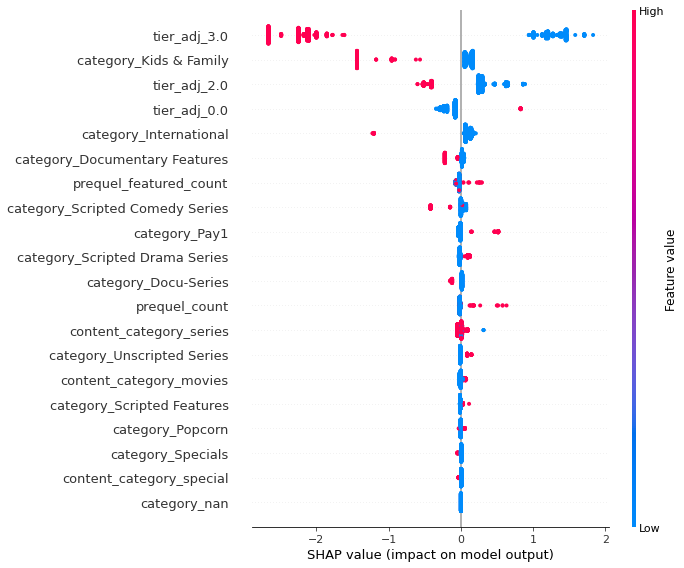

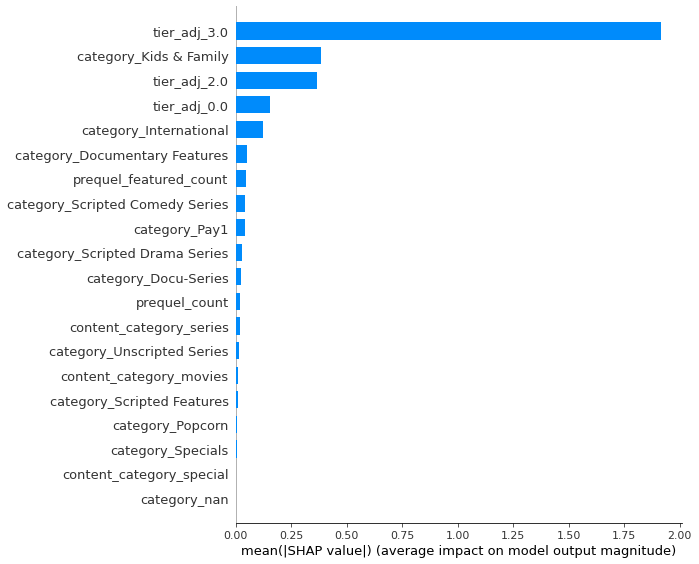

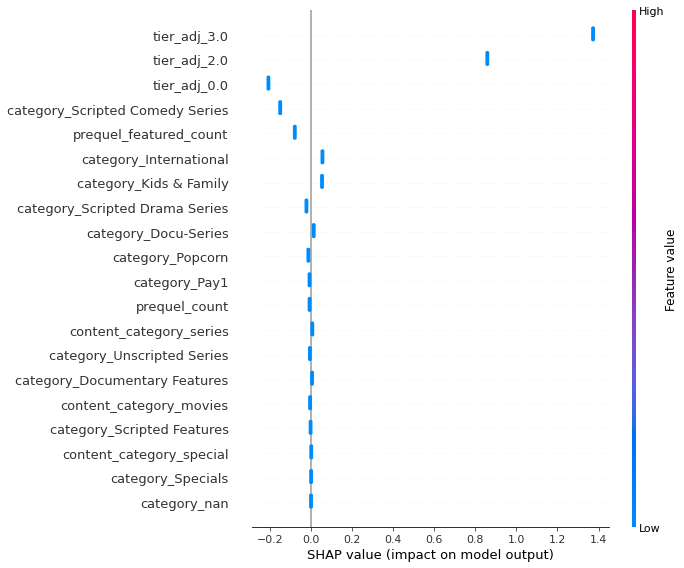

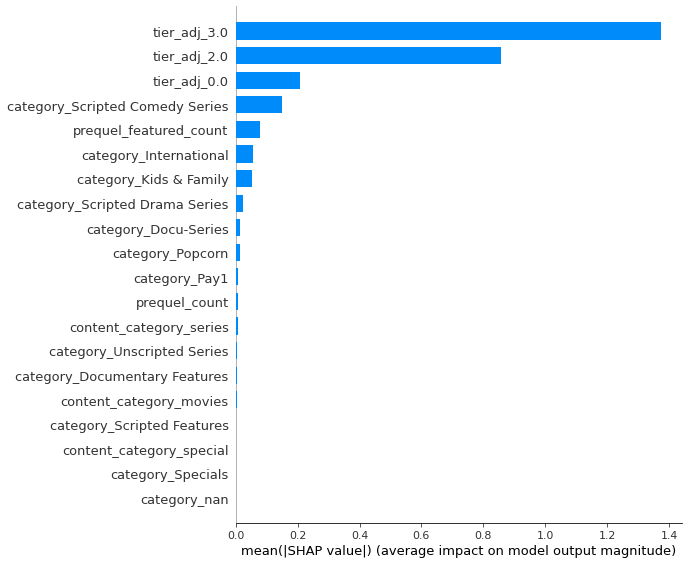

In [57]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

dict_model = Utils.read_pkl_s3(f'fv_{date_train}.pkl')
model = dict_model['model']
ohe = dict_model['ohe']
features_cat=['tier_adj','category','content_category']
features_cont=['prequel_count', 'prequel_featured_count']
df_test = df_in_pred.copy()

ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont)
ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains('Just Like')], model, ohe, features_cat + features_cont)

shap.force_plot(ev, shap_values, x_ohe)

## Future Program

INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.2, Python Version: 3.6.13, Platform: Linux-4.14.252-131.483.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
INFO:snowflake.connector.connection:Setting use_openssl_only mode to False
INFO:snowflake.connector.cursor:query: [select * from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST]
INFO:snowflake.connector.cursor:query execution done


579
513
title_name                0
tier_cat                  0
tier                      0
tier_adj                  0
season_number             0
content_category          0
category                  0
effective_start_date      0
first_view_month          0
first_view_quarter        0
prequel_count             0
prequel_featured_count    0
first_views_xgb           0
first_views_rwm           0
dtype: int64


,first_view_quarter,first_views_xgb,first_views_rwm,pred_diff_million,pct_pred_diff
10,2024Q3,2691731.0,4146774.0,-1.46,-0.35
11,2024Q4,2268649.0,3439093.0,-1.17,-0.34
5,2023Q2,2357160.0,3452676.0,-1.10,-0.32
6,2023Q3,1881926.0,2875483.0,-0.99,-0.35
7,2023Q4,2157957.0,3125061.0,-0.97,-0.31
9,2024Q2,2260395.0,3076757.0,-0.82,-0.27
8,2024Q1,1801453.0,2557051.0,-0.76,-0.30
2,2022Q3,2169349.0,2765568.0,-0.60,-0.22
4,2023Q1,2006273.0,2595996.0,-0.59,-0.23
1,2022Q2,2096781.0,2495539.0,-0.40,-0.16


first_views_xgb      2.065302e+06
first_views_rwm      2.840799e+06
pred_diff_million   -7.754968e-01
pct_pred_diff       -2.553390e-01
dtype: float64

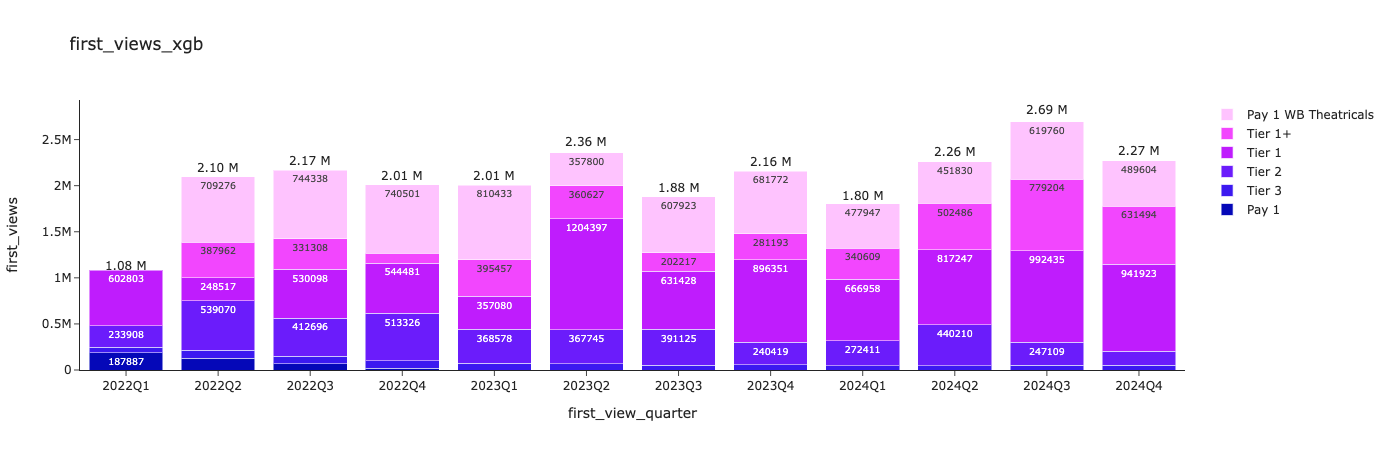

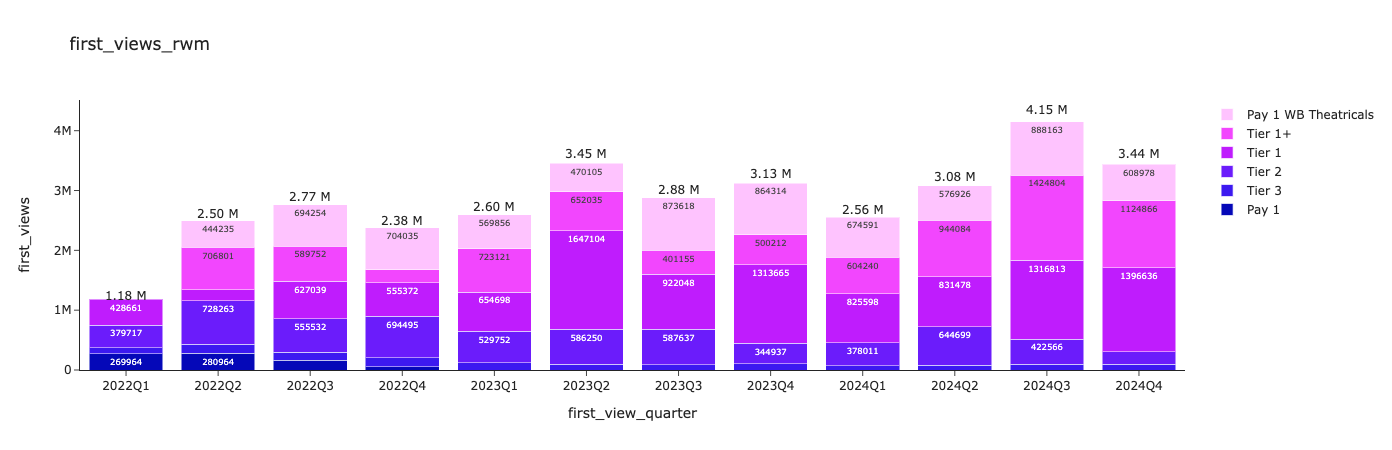

,first_view_quarter,tier_cat,first_views_xgb,first_views_rwm,pred_diff_million,pct_pred_diff
0,2022Q1,Pay 1,187887.0,269964.0,-0.082077,-0.304029
1,2022Q1,Tier 1,602803.0,428661.0,0.174142,0.406246
2,2022Q1,Tier 2,233908.0,379717.0,-0.145809,-0.383994
3,2022Q1,Tier 3,59499.0,100946.0,-0.041447,-0.410586
4,2022Q2,Pay 1,129435.0,280964.0,-0.151529,-0.539318
5,2022Q2,Pay 1 WB Theatricals,709276.0,444235.0,0.265041,0.596623
6,2022Q2,Tier 1,248517.0,187896.0,0.060621,0.322631
7,2022Q2,Tier 1+,387962.0,706801.0,-0.318839,-0.451102
8,2022Q2,Tier 2,539070.0,728263.0,-0.189193,-0.259787
9,2022Q2,Tier 3,82521.0,147380.0,-0.064859,-0.440080


,first_views_xgb,first_views_rwm,pred_diff_million,pct_pred_diff
first_view_quarter,,,,
2024Q3,538346.20,829354.80,-0.29,-0.37
2024Q4,453730.00,687818.60,-0.23,-0.34
2023Q2,471432.00,690535.20,-0.22,-0.33
2023Q3,376385.20,575096.60,-0.20,-0.38
2023Q4,431591.40,625012.00,-0.19,-0.34
2024Q2,452078.80,615351.40,-0.16,-0.28
2024Q1,360290.80,511410.20,-0.15,-0.32
2023Q1,401254.80,519199.20,-0.12,-0.23
2022Q3,361558.33,460928.00,-0.10,-0.29


,first_views_xgb,first_views_rwm,pred_diff_million,pct_pred_diff
tier_cat,,,,
Tier 1+,392692.36,717472.64,-0.32,-0.46
Tier 1,702809.83,892250.67,-0.19,-0.13
Tier 2,348448.17,505616.67,-0.16,-0.31
Pay 1,100977.75,191563.50,-0.09,-0.52
Pay 1 WB Theatricals,608289.45,669915.91,-0.06,-0.06
Tier 3,62818.50,107304.17,-0.04,-0.41


first_views_xgb  first_views_rwm  \
tier_cat             category                                                   
Tier 1               Scripted Features             243520.20        626740.10   
Tier 1+              Scripted Drama Series         392692.36        717472.64   
Pay 1                Pay1                          100977.75        191563.50   
Pay 1 WB Theatricals Pay 1 WB Theatricals          608289.45        669915.91   
Tier 2               Documentary Features           63335.83        116803.50   
                     Scripted Comedy Series         72322.75        121690.42   
                     Unscripted Series              41069.25         77631.67   
                     Docu-Series                    37613.27         51899.64   
Tier 3               Kids & Family                   5556.00         19807.50   
                     Unscripted Series              10844.58         21113.75   
                     Scripted Drama Series           5028.67         13933.50   
Tier 2               Kids & Family                   6505.58         14563.08   
Tier 3               Docu-Series                     9852.33         17272.83   
                     Documentary Features           16497.50         22143.75   
Tier 2               Scripted Features              55303.25         58692.67   
Tier 3               Scripted Features               2665.50          5507.50   
                     International                   1914.89          3760.00   
                     Specials                        5429.67          7195.83   
Tier 2               International                   3925.25          4418.50   
Tier 3               Scripted Comedy Series         12958.33         12663.75   
Tier 1               Scripted Comedy Series         95414.14         92539.00   
Tier 2               Scripted Drama Series          80862.73         73295.82   
Tier 1               Kids & Family                  49066.00             0.00   
                     Scripted Drama Series         436040.25        315986.17   

                                             pred_diff_million  pct_pred_diff  
tier_cat             category                                                  
Tier 1               Scripted Features                   -0.38          -0.61  
Tier 1+              Scripted Drama Series               -0.32          -0.46  
Pay 1                Pay1                                -0.09          -0.52  
Pay 1 WB Theatricals Pay 1 WB Theatricals                -0.06          -0.06  
Tier 2               Documentary Features                -0.05          -0.45  
                     Scripted Comedy Series              -0.05          -0.40  
                     Unscripted Series                   -0.04          -0.48  
                     Docu-Series                         -0.01          -0.28  
Tier 3               Kids & Family                       -0.01          -0.72  
                     Unscripted Series                   -0.01          -0.50  
                     Scripted Drama Series               -0.01          -0.64  
Tier 2               Kids & Family                       -0.01          -0.56  
Tier 3               Docu-Series                         -0.01          -0.43  
                     Documentary Features                -0.01          -0.25  
Tier 2               Scripted Features                   -0.00          -0.04  
Tier 3               Scripted Features                   -0.00          -0.47  
                     International                       -0.00          -0.49  
                     Specials                            -0.00          -0.24  
Tier 2               International                       -0.00          -0.15  
Tier 3               Scripted Comedy Series               0.00           0.01  
Tier 1               Scripted Comedy Series               0.00           0.00  
Tier 2               Scripted Drama Series                0.01           0.10  
Tier 1            

tier_cat             Pay 1Tier 1Tier 2Tier 2Tier 2Tier 2Tier 2Tier ...
category             Pay1Scripted Drama SeriesDocumentary FeaturesK...
first_views_xgb                                            2.47836e+07
first_views_rwm                                            3.40896e+07
pred_diff_million                                             -9.30596
pct_pred_diff                                                      inf
dtype: object


In [3]:
def get_filtered_first_views_future(df_in, offset, grpby_title, first_view_date_col):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting next 3 months? 
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()

    ## select rows where first_view_months are within offset months + prediction date
#     df_in = df_in[(df_in['first_view_month']<= df_in['pred_date'] + pd.DateOffset(months=offset))]  
    return df_in

def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def get_tier_cat(df_pred_future_fv):
    ### Get tier_cat 
    f_pay = (df_pred_future_fv['category']=='Pay1')
    f_payt = (df_pred_future_fv['category']=='Pay 1 WB Theatricals')
    f_popcorn = (df_pred_future_fv['category']=='Popcorn')
    f_t0 = (df_pred_future_fv['tier']==0) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t1 = (df_pred_future_fv['tier']==1) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t2 = (df_pred_future_fv['tier']==2) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))
    f_t3 = (df_pred_future_fv['tier']==3) & ~(df_pred_future_fv['category'].isin(['Pay1','Popcorn','Pay 1 WB Theatricals']))

    df_pred_future_fv['tier_cat'] = None
    # df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay1 Theatrical'
    df_pred_future_fv.loc[f_pay, 'tier_cat'] = 'Pay 1'
    df_pred_future_fv.loc[f_payt, 'tier_cat'] = 'Pay 1 WB Theatricals'
    df_pred_future_fv.loc[f_popcorn, 'tier_cat'] = 'Popcorn'
    df_pred_future_fv.loc[f_t0, 'tier_cat'] = 'Tier 1+'
    df_pred_future_fv.loc[f_t1, 'tier_cat'] = 'Tier 1'
    df_pred_future_fv.loc[f_t2, 'tier_cat'] = 'Tier 2'
    df_pred_future_fv.loc[f_t3, 'tier_cat'] = 'Tier 3'
    return df_pred_future_fv

def get_stacked_plot(df_plt, var):
    fig = go.Figure()
    tier_cat_list = ['Pay 1', 'Tier 3','Tier 2','Tier 1','Tier 1+','Popcorn','Pay 1 WB Theatricals',]  ## px.colors.sequential.Plotly3

    for r, c in zip(tier_cat_list,  ['#0508b8','#3c19f0','#6b1cfb','#bf1cfd','#f246fe','#fe88fc','#fec3fe']):
        plot_df = df_plt[df_plt.tier_cat == r]
        fig.add_trace(
            go.Bar(x=plot_df.first_view_quarter, y=plot_df[var], name=r, marker_color=c, 
                   text=plot_df[var], textposition='inside', textangle=0) ,
        )

    annotation=[]    
    quarters=df_plt.first_view_quarter.unique().tolist()
    models = ['xgb','rwm']
    for q in quarters:#, m in itertools.product(quarters, models):
        plot_df = df_plt[(df_plt.first_view_quarter==q)]    
        dic= {"x":q, "y": plot_df[var].sum()*1.05,
                     "text": f'{plot_df[var].sum()/1000000:.2f} M', 
                     "showarrow": False} 
        annotation.append(dic)


    fig.update_layout(
        template="simple_white",
        title=var,
        xaxis=dict(title_text="first_view_quarter"),
        yaxis=dict(title_text="first_views"),
        barmode="stack",
        uniformtext_minsize=8, 
        uniformtext_mode='hide',
        annotations=annotation
    )

    py.offline.iplot(fig)
    return 

## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

## Title total 
querystr = '''
select * 
from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
'''

cursor_list = ctx.execute_string(
    querystr
    )
df_rwm = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_rwm = df_rwm.fillna(0)
df_rwm.columns= df_rwm.columns.str.lower()
df_rwm.head(2)

df_rwm['effective_start_date'] = pd.to_datetime(df_rwm['effective_start_date'])
df_rwm['request_date'] = pd.to_datetime(df_rwm['request_date'])
df_rwm['start_month'] = pd.to_datetime(df_rwm['effective_start_date']).dt.to_period('M').dt.to_timestamp()
df_rwm['first_view_month'] = df_rwm['request_date'].dt.to_period('M').dt.to_timestamp()
df_rwm['first_view_quarter'] = df_rwm['request_date'].dt.to_period('Q').dt.to_timestamp()
df_rwm.loc[(df_rwm.category=='Popcorn') & (df_rwm.effective_start_date>='2022-04-01'), 'category']='Pay 1 WB Theatricals'
df_rwm.loc[(df_rwm.category=='Pay 1 WB Theatricals'), 'predicted_first_views']=df_rwm['predicted_first_views']*0.7
df_rwm = df_rwm.rename(columns={'predicted_first_views':'first_views_rwm'})
# df_rwm = df_rwm[df_rwm.effective_start_date>='2021-10-01']
df_rwm = df_rwm[df_rwm.schedule_label==schedule]


offset=2
agg_var = 'first_view_month'
df_pred_decay['content_category']=0

grpby_title= ['title_name','tier','tier_adj','season_number','category', 'content_category', 'effective_start_date','prequel_count','prequel_featured_count',]
df_decay_future = get_filtered_first_views_future(df_pred_decay, offset, grpby_title, 'request_date')
df_pred_future_fv_xgb = get_agg_first_views(df_decay_future,  agg_var,grpby_title,'request_date', [f'first_views_pred_decay'])
df_pred_future_fv_xgb['first_view_quarter'] = df_pred_future_fv_xgb['first_view_month'].dt.to_period('Q')
df_pred_future_fv_xgb = get_tier_cat(df_pred_future_fv_xgb)
df_pred_future_fv_xgb['model'] = 'xgb'
df_pred_future_fv_xgb = df_pred_future_fv_xgb.rename(columns={'first_views_pred_decay':'first_views_xgb'})

grpby_title_rwm= ['title_name','tier','season_number','category','effective_start_date','schedule_label']
# df_decay_future_rwm = get_filtered_first_views_future(df_pred_decay_future, offset, grpby_title, 'request_date')
df_pred_future_fv_rwm = get_agg_first_views(df_rwm, agg_var, grpby_title_rwm,  'request_date', ['first_views_rwm'])
df_pred_future_fv_rwm['first_view_quarter'] = df_pred_future_fv_rwm['first_view_month'].dt.to_period('Q')
df_pred_future_fv_rwm['tier'] = df_pred_future_fv_rwm['tier'].astype(int)
df_pred_future_fv_rwm = get_tier_cat(df_pred_future_fv_rwm)
df_pred_future_fv_rwm['model'] = 'rwm'
df_pred_future_fv_rwm = df_pred_future_fv_rwm.rename(columns={'first_views_rwm':'first_views_rwm'})


print(df_pred_future_fv_xgb[(df_pred_future_fv_xgb['first_view_quarter']>'2021Q4') & (df_pred_future_fv_xgb['first_view_quarter']<'2025Q1')].title_name.nunique())
print(df_pred_future_fv_rwm[(df_pred_future_fv_rwm['first_view_quarter']>'2021Q4') & (df_pred_future_fv_rwm['first_view_quarter']<'2025Q1')].title_name.nunique())

## Groupby tier_cat quarter 
grpby_quarter= ['first_view_quarter','tier_cat']
df_pred_future_fv = df_pred_future_fv_rwm.merge(df_pred_future_fv_xgb, on=['title_name', 'tier', 'tier_cat', 'season_number', 'category', 'first_view_month','first_view_quarter', 'effective_start_date', 'tier_cat'], suffixes=['_xgb','_rwm'], how='left')
df_pred_future_fv = df_pred_future_fv[['title_name', 'tier_cat', 'tier', 'tier_adj', 'season_number', 'content_category', 'category',
       'effective_start_date',  'first_view_month', 'first_view_quarter', 
       'prequel_count', 'prequel_featured_count', 'first_views_xgb','first_views_rwm']]
print(df_pred_future_fv.isnull().sum())
# df_rwm_future_grp = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_rwm_dash.csv')


## Group by title 
df_pred_future_fv_title = df_pred_future_fv.groupby(by=['tier_cat']+ grpby_title)[['first_views_xgb','first_views_rwm']].sum().reset_index()

## Group by quarter
df_plt = df_pred_future_fv.groupby(by=['first_view_quarter'])[['first_views_xgb','first_views_rwm']].sum().reset_index().round()
df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_rwm'])/1000000
df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_rwm'])/df_plt['first_views_rwm']
display(df_plt.sort_values(by='pred_diff_million', ascending=True).round(2))
display(df_plt.mean())


## Group by quarter - tier_cat
df_pred_future_fv_quarter = df_pred_future_fv.groupby(by=grpby_quarter)[['first_views_xgb','first_views_rwm']].sum().reset_index()
df_plt = df_pred_future_fv_quarter.round()
df_plt = df_plt[(df_plt['first_view_quarter']>'2021Q4') & (df_plt['first_view_quarter']<'2025Q1')]
df_plt['first_view_quarter'] = df_plt['first_view_quarter'].astype(str)
get_stacked_plot(df_plt, 'first_views_xgb')
get_stacked_plot(df_plt, 'first_views_rwm')

df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_rwm'])/1000000
df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_rwm'])/df_plt['first_views_rwm']
display(df_plt.sum())
display(df_plt.groupby(by=['first_view_quarter']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))
display(df_plt.groupby(by=['tier_cat']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))

## Group by quarter- tier_cat- category 
df_plt = df_pred_future_fv.groupby(by=['first_view_quarter','tier_cat','category'])[['first_views_xgb','first_views_rwm']].sum().reset_index().round()
df_plt['pred_diff_million'] = (df_plt['first_views_xgb']-df_plt['first_views_rwm'])/1000000
df_plt['pct_pred_diff'] = (df_plt['first_views_xgb']-df_plt['first_views_rwm'])/df_plt['first_views_rwm']
display(df_plt.groupby(by=['tier_cat','category']).mean().sort_values(by='pred_diff_million', ascending=True).round(2))
print(df_plt.sum())


In [41]:
list_name = ['AN AMERICAN PICKLE',
'UNPREGNANT',
'CHARM CITY KINGS',
'SUPERINTELLIGENCE',
'LET THEM ALL TALK',
'LOCKED DOWN',
'NO SUDDEN MOVE',
'8-BIT CHRISTMAS',
'THE FALLOUT',
'KIMI',
'MOONSHOT']

list_name = [str.title(i) for i in list_name]
print(list_name)

df_pred[df_pred.title_name.isin(list_name)]

['An American Pickle', 'Unpregnant', 'Charm City Kings', 'Superintelligence', 'Let Them All Talk', 'Locked Down', 'No Sudden Move', '8-Bit Christmas', 'The Fallout', 'Kimi', 'Moonshot']


,title_name,category,prequel_featured_count,tier_adj,content_category,tier,prequel_count,effective_start_date,season_number,first_views_log_pred,first_views_pred,pred_date,decay_category
10,8-Bit Christmas,Scripted Features,0.0,2,movies,2,0.0,2021-11-25,0,10.440562,34219.886719,2022-01-13,Scripted Features
354,Kimi,Scripted Features,0.0,2,movies,2,0.0,2022-02-17,0,10.440562,34219.886719,2022-01-13,Scripted Features
430,Moonshot,Scripted Features,0.0,2,movies,2,0.0,2022-03-24,0,10.440562,34219.886719,2022-01-13,Scripted Features
605,The Fallout,Scripted Features,0.0,2,movies,2,0.0,2022-01-27,0,10.440562,34219.886719,2022-01-13,Scripted Features


In [10]:
col = ['title_name','tier','category','effective_start_date','prequel_count','prequel_featured_count','first_views_xgb_','first_views_rwm_']

for i in [0,1,2,3]:
    display(df_in_train[(df_in_train.tier==i)][col[:-2]+['first_views']][['tier','category','title_name','effective_start_date','first_views']].drop_duplicates().sort_values(by='effective_start_date', ascending=False).head(10))


,tier,category,title_name,effective_start_date,first_views
294,0,Popcorn,The Suicide Squad,2021-08-05,550775
229,0,Popcorn,Space Jam: A New Legacy,2021-07-16,669145
246,0,Popcorn,The Conjuring: The Devil Made Me Do It,2021-06-04,571179
77,0,Specials,Friends: The Reunion,2021-05-27,867873
158,0,Popcorn,Mortal Kombat,2021-04-23,1000000
83,0,Popcorn,Godzilla vs. Kong,2021-03-31,1000000
331,0,Scripted Features,Zack Snyder's Justice League,2021-03-18,1000000
312,0,Popcorn,Tom & Jerry,2021-02-26,595725
275,0,Popcorn,The Little Things,2021-01-29,635594
327,0,Popcorn,Wonder Woman 1984,2020-12-25,1000000


,tier,category,title_name,effective_start_date,first_views
51,1,Popcorn,Cry Macho,2021-09-17,133024
153,1,Popcorn,Malignant,2021-09-10,136819
195,1,Popcorn,Reminiscence,2021-08-20,68790
84,1,Pay1,Godzilla vs. Kong,2021-08-17,79777
311,1,Scripted Drama Series,Titans,2021-08-12,83173
301,1,Scripted Drama Series,The White Lotus,2021-07-12,143183
89,1,Scripted Drama Series,Gossip Girl,2021-07-08,108617
114,1,Popcorn,In the Heights,2021-06-10,195267
303,1,Popcorn,Those Who Wish Me Dead,2021-05-14,153271
328,1,Pay1,Wonder Woman 1984,2021-05-13,70744


,tier,category,title_name,effective_start_date,first_views
277,2,Popcorn,The Many Saints of Newark,2021-10-01,235919
201,2,Scripted Drama Series,Scenes From a Marriage,2021-09-13,37747
141,2,Kids & Family,Little Ellen,2021-09-13,779
159,2,Pay1,Mortal Kombat,2021-09-09,73519
290,2,Scripted Comedy Series,The Prince,2021-07-29,26240
123,2,Kids & Family,Jellystone,2021-07-29,2723
313,2,Pay1,Tom & Jerry,2021-07-15,58320
137,2,Pay1,Let Him Go,2021-07-04,26177
170,2,Scripted Features,No Sudden Move,2021-07-01,50457
72,2,Pay1,Fatale,2021-06-20,14711


,tier,category,title_name,effective_start_date,first_views
304,3,Pay1,Those Who Wish Me Dead,2021-09-30,11263
285,3,Kids & Family,The Not-Too-Late Show With Elmo,2021-09-30,140
240,3,International,The American Guest (El huésped americano),2021-09-28,948
171,3,Docu-Series,Nuclear Family,2021-09-27,1706
187,3,Pay1,Promising Young Woman,2021-09-26,11369
16,3,Specials,Ahir Shah: Dots,2021-09-23,2816
139,3,Docu-Series,Level Playing Field,2021-09-15,1005
132,3,International,Laetitia,2021-08-31,2511
95,3,Pay1,Half Brothers,2021-08-21,6025
155,3,Specials,Marlon Wayans: You Know What It Is,2021-08-19,8094


In [46]:
### Pay 1 WB Theatrical
df_in_train['first_views_'] = (df_in_train['first_views']/1000).astype(int)
df_pred_future_fv_title['first_views_xgb_'] = (df_pred_future_fv_title['first_views_xgb']/1000).astype(int)
df_pred_future_fv_title['first_views_rwm_'] = (df_pred_future_fv_title['first_views_rwm']/1000).astype(int)

col = ['title_name','effective_start_date','tier','category', 'prequel_count','prequel_featured_count','first_views_xgb_','first_views_rwm_']
display(df_in_train[(df_in_train.category=='Popcorn') & (df_in_train.tier==1)][col[:-2]+['first_views_']][['title_name','effective_start_date','first_views_']].drop_duplicates().sort_values(by='effective_start_date'))
display(df_pred_future_fv_title[df_pred_future_fv_title.tier_cat=='Pay 1 WB Theatricals'][col].sort_values(by='effective_start_date')[['title_name','effective_start_date','prequel_count','prequel_featured_count','first_views_xgb_','first_views_rwm_']].round().head(5))

## Tier 1+, 1
for tier in [0, 1]:
    col = ['title_name','effective_start_date','prequel_count','prequel_featured_count','first_views_xgb_','first_views_rwm_']
    cat_list = df_pred_future_fv_title[(df_pred_future_fv_title.tier_adj==tier)].category.unique().tolist()
    try:
        cat_list.remove('Pay 1 WB Theatricals')
    except:
        pass
    
    for i in cat_list:
        print('---------------------------------------------')
        print(f'tier {tier}, {i}')
        display(df_in_train[(df_in_train.category==i) & (df_in_train.tier_adj==tier)][col[:-2]+['first_views_']][['title_name','effective_start_date','first_views_']].drop_duplicates().sort_values(by='effective_start_date'))
        display(df_pred_future_fv_title[(df_pred_future_fv_title.category==i) & (df_pred_future_fv_title.tier_adj==tier)][col].sort_values(by='effective_start_date')[col].round().head(5))



,title_name,effective_start_date,first_views_
126,Judas and the Black Messiah,2021-02-12,319
300,Those Who Wish Me Dead,2021-05-14,153
114,In the Heights,2021-06-10,195
193,Reminiscence,2021-08-20,68
151,Malignant,2021-09-10,136
51,Cry Macho,2021-09-17,133
274,The Many Saints of Newark,2021-10-01,235


,title_name,effective_start_date,prequel_count,prequel_featured_count,first_views_xgb_,first_views_rwm_
59,The Batman,2022-04-18,5.0,15.0,177,246
55,Fantastic Beasts: The Secrets of Dumbledore,2022-05-30,2.0,16.0,177,246
51,DC League Of Super-Pets,2022-07-04,1.0,0.0,168,246
54,Elvis,2022-08-08,0.0,0.0,153,246
49,Black Adam,2022-09-12,1.0,20.0,228,246


---------------------------------------------
tier 0, Scripted Drama Series


,title_name,effective_start_date,first_views_
251,The Flight Attendant,2020-11-26,758


,title_name,effective_start_date,prequel_count,prequel_featured_count,first_views_xgb_,first_views_rwm_
132,The Flight Attendant,2022-04-21,-1.0,-1.0,467,758
129,House Of The Dragon,2022-08-21,-1.0,-1.0,467,758
134,The Last Of Us,2023-01-15,-1.0,-1.0,467,758
133,The Flight Attendant,2023-05-11,-1.0,-1.0,467,758
126,DCU Green Lantern,2023-09-14,-1.0,-1.0,467,758


---------------------------------------------
tier 1, Scripted Drama Series


,title_name,effective_start_date,first_views_
146,Lovecraft Country,2020-08-17,293
189,Raised by Wolves,2020-09-03,360
294,The Undoing,2020-10-26,420
152,Mare of Easttown,2021-04-19,184
89,Gossip Girl,2021-07-08,108
298,The White Lotus,2021-07-12,143


,title_name,effective_start_date,prequel_count,prequel_featured_count,first_views_xgb_,first_views_rwm_
75,Euphoria,2022-01-09,-1.0,-1.0,159,123
96,Peacemaker,2022-01-13,-1.0,-1.0,159,123
109,The Gilded Age,2022-01-24,-1.0,-1.0,159,123
122,Winning Time: The Rise Of The Lakers Dynasty,2022-03-06,-1.0,-1.0,159,123
104,Raised By Wolves,2022-03-24,-1.0,-1.0,159,123


---------------------------------------------
tier 1, Scripted Comedy Series


,title_name,effective_start_date,first_views_
143,Love Life,2020-05-27,242


,title_name,effective_start_date,prequel_count,prequel_featured_count,first_views_xgb_,first_views_rwm_
112,The Sex Lives of College Girls,2022-11-17,-1.0,-1.0,140,320
64,And Just Like That,2023-06-08,-1.0,-1.0,140,320
113,The Sex Lives of College Girls,2023-11-16,-1.0,-1.0,140,320
65,And Just Like That,2024-10-03,-1.0,-1.0,140,319
114,The Sex Lives of College Girls,2024-11-14,-1.0,-1.0,122,276


---------------------------------------------
tier 1, Scripted Features


,title_name,effective_start_date,first_views_
199,Scoob!,2020-06-26,136
21,An American Pickle,2020-08-06,117
40,Charm City Kings,2020-10-08,352
196,Roald Dahl’s The Witches,2020-10-22,524


,title_name,effective_start_date,prequel_count,prequel_featured_count,first_views_xgb_,first_views_rwm_
77,Father of the Bride Latinx,2022-07-21,0.0,0.0,139,352
67,Batgirl (DC),2022-12-15,0.0,0.0,139,352
119,Wedding Crashers 2,2023-03-15,0.0,0.0,139,352
78,Final Destination 6,2023-03-16,0.0,0.0,139,352
117,Training Day Prequel,2023-04-20,0.0,0.0,139,352


---------------------------------------------
tier 1, Kids & Family


,title_name,effective_start_date,first_views_


,title_name,effective_start_date,prequel_count,prequel_featured_count,first_views_xgb_,first_views_rwm_
80,Harry Potter Retrospective,2022-01-15,0.0,0.0,120,0
103,Quizzarding World,2022-12-01,-1.0,-1.0,120,0


## Backtest evaluation


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


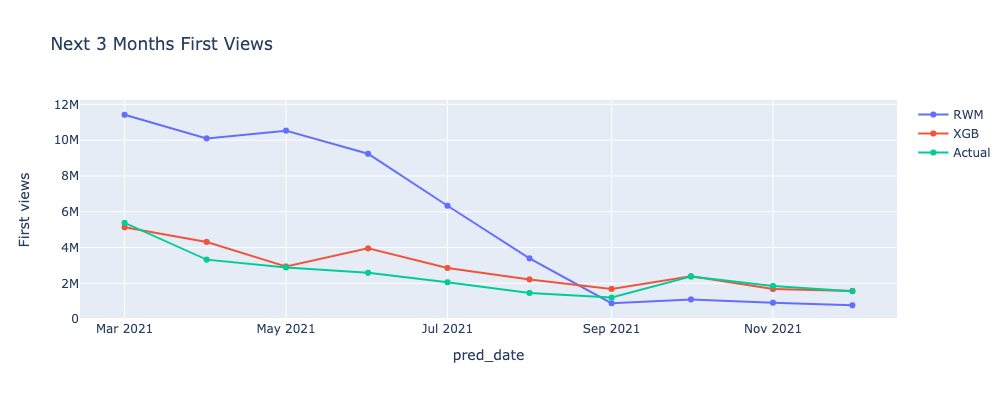

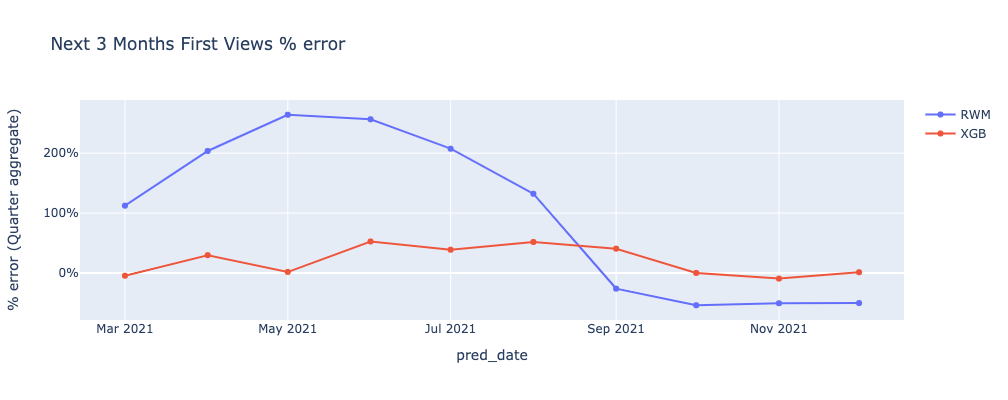

pct_error_first_views_pred_decay    23.077729
dtype: float64

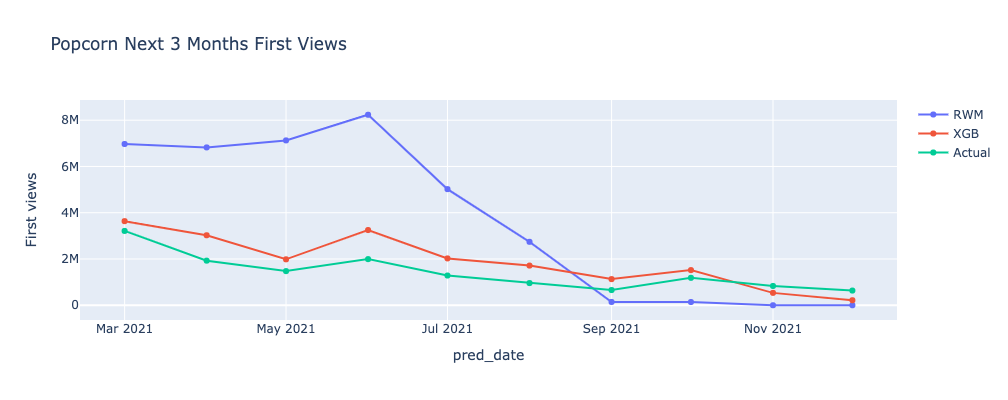

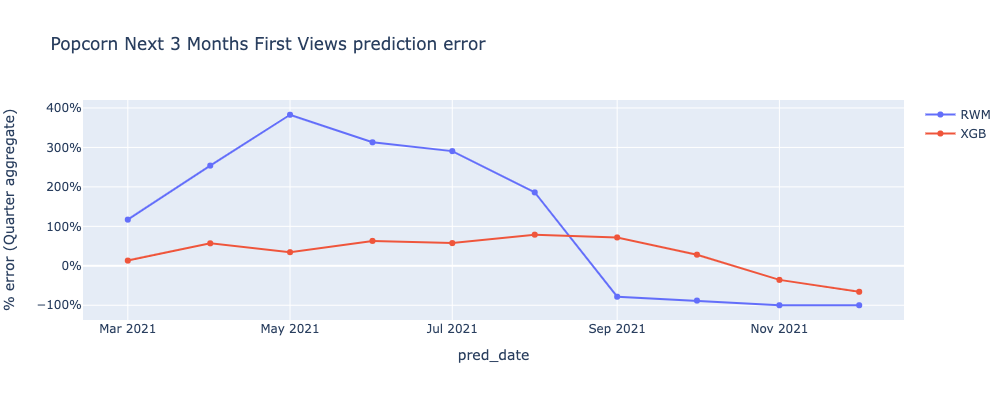

pct_error_first_views_pred_decay    50.575135
dtype: float64

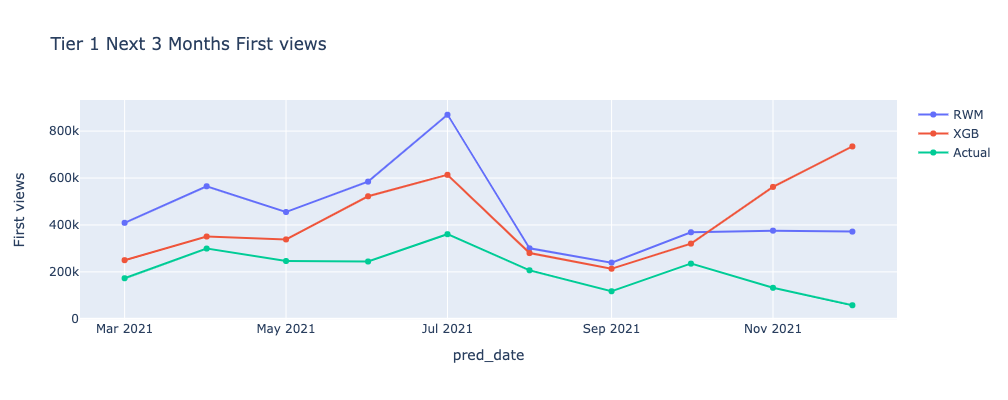

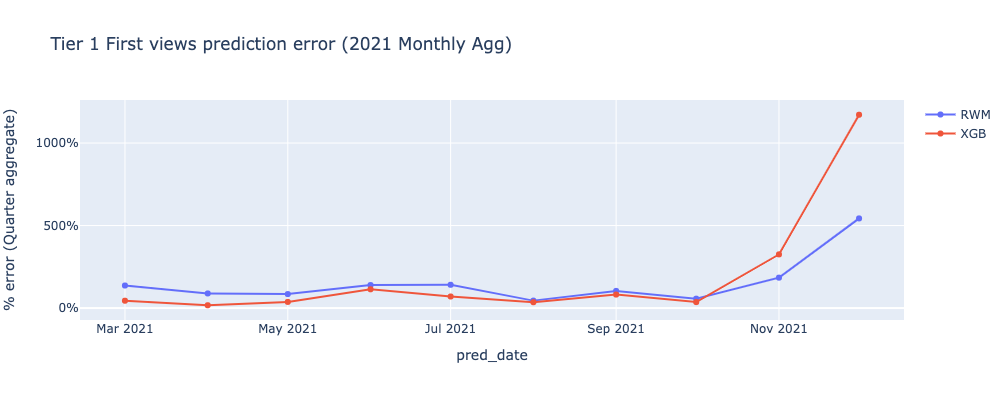

pct_error_first_views_pred_decay    193.350396
dtype: float64

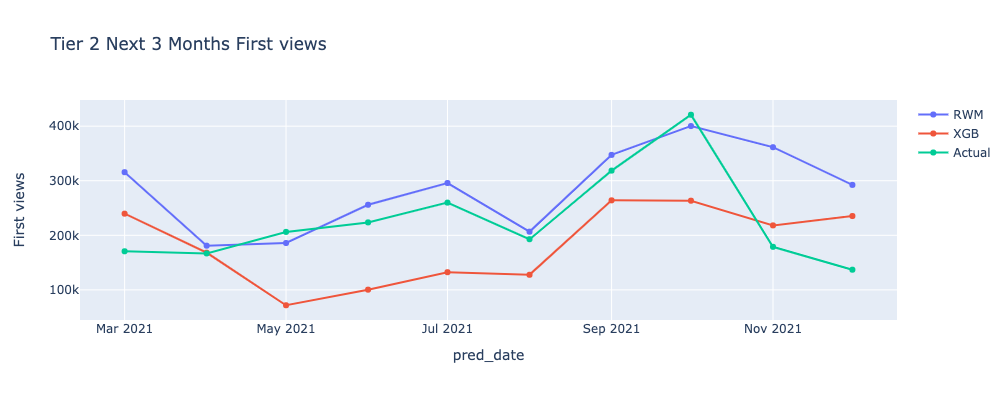

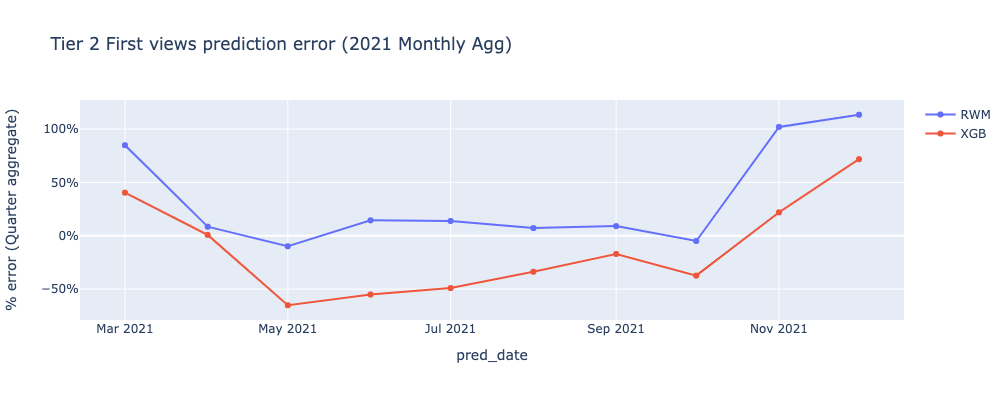

pct_error_first_views_pred_decay    39.256372
dtype: float64

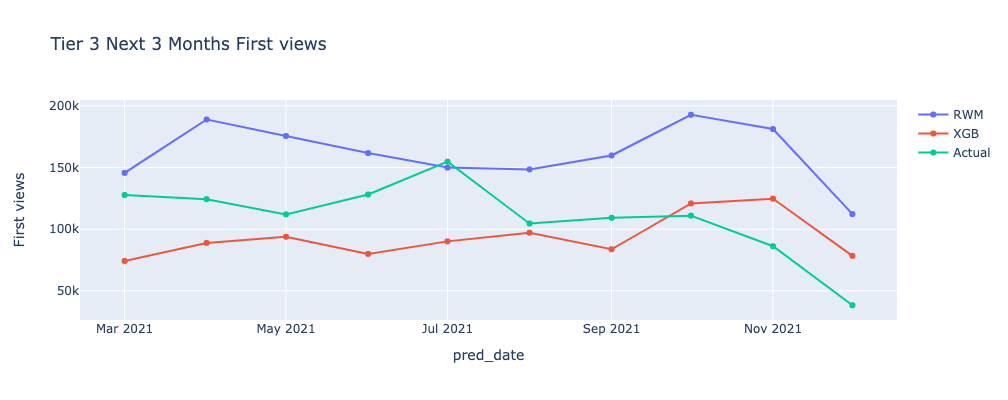

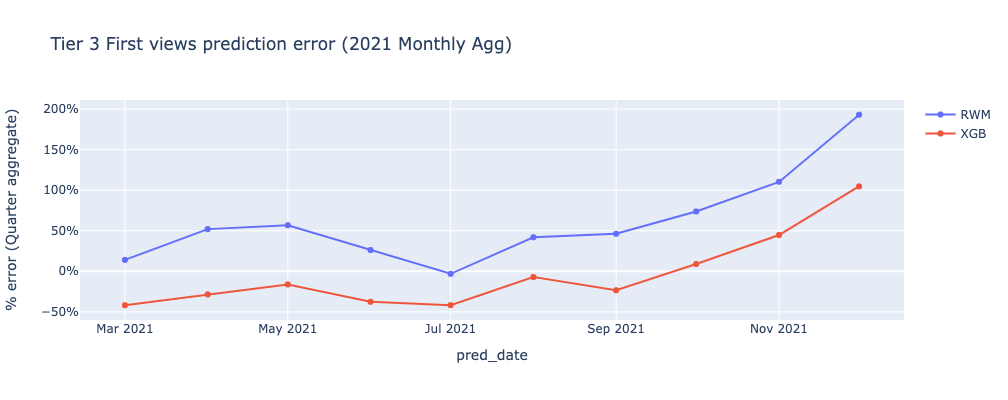

pct_error_first_views_pred_decay    35.489651
dtype: float64

In [21]:
def get_filtered_first_views(df_in, offset, first_view_date_col):
    ## Get predictions according to the offset 
    ## e.g. How good are we in predicting next 3 months? 
    df_in['pred_date'] = pd.to_datetime(df_in['pred_date'])
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()

    ## select rows where first_view_months are within offset months + prediction date
    df_in = df_in[(df_in['first_view_month']<= df_in['pred_date'] + pd.DateOffset(months=offset))]  
    return df_in
    
def get_agg_first_views(df_in, agg_col, grpby_title, first_view_date_col, first_view_col):
    grpby_title_agg = grpby_title + [agg_col]
    df_in[first_view_date_col] = pd.to_datetime(df_in[first_view_date_col])
    df_in['first_view_quarter'] = df_in[first_view_date_col].dt.to_period("Q").dt.to_timestamp()   
    df_in['first_view_month'] = df_in[first_view_date_col].dt.to_period('M').dt.to_timestamp()
    df_in = df_in[grpby_title_agg + first_view_col].groupby(by=grpby_title_agg).sum().reset_index()
    return df_in

def evaluate_pred_plt(df_plt, grpby, var_list):
    mean_var_list = [f'mae_{i}' for i in var_list]
    sum_var_list = ['first_views'] + var_list 
    mean_dic = dict(zip(mean_var_list, ['mean'] * len(mean_var_list)))
    sum_dic = dict(zip(sum_var_list, ['sum'] * len(sum_var_list)))
    
    # Get absolute error at agg_time- title level
    df_grp = df_plt.groupby(by=grpby).agg(sum_dic).reset_index()
    for i in var_list:
        df_grp[f'mae_{i}'] = (df_grp[i] - df_grp['first_views']).abs()  ## mae is actually ae here. mean taken in the next step

    ## aggregate to agg_time level (month, quarter)
    agg_dic =  {k: v for d in (mean_dic, sum_dic) for k, v in d.items()}
    df_grp = df_grp.groupby(by=grpby[:-2]).agg(agg_dic).reset_index()
    for i in var_list:
        df_grp[f'pct_error_{i}'] = (df_grp[i] - df_grp['first_views'])/df_grp['first_views']*100

    return df_grp

def get_plot(dflist, varlist, labellist=None,  ## Old
              title=None, config={}, x_var='order_date', y_var='y_var',  mode='lines+markers'):
    ## Create dataframe x var combinations (plot all variables for each dataframe)
    dfvarlist=itertools.product(*[dflist,varlist])
        
    ## For every dataframe x variable, create a data trace for plotting
    data=[]    
    for dfvar, name in zip(dfvarlist, labellist):
        dfplt,var=dfvar[0], dfvar[1]
        data = data + [go.Scatter(x=dfplt[x_var], y=dfplt[var], mode=mode, name=name)]  

    ## Initiate offline plot and create plot
    py.offline.init_notebook_mode(connected=True) 
    layout = dict(title = title,
                  xaxis = dict(title = x_var), #, range=['2017-09-01','2017-02-01']
                  yaxis = dict(title = y_var),
                  autosize=False,
                  width=(600),
                  height=(400),
                  showlegend=True,
                 )
    fig = dict(data=data, layout=layout)
    return fig

def get_pred_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':['first_views_rwm', f'first_views_pred_decay','first_views'] ## Variables to be plotted
            ,'title': title  ## Plot title
            ,'labellist':['RWM', 'XGB', 'Actual'] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': 'First views'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    py.offline.iplot(fig)
    return 

def get_pct_error_plot(df_grp, agg_var, title):

    kwargs={'dflist':[df_grp]  ## List of dataframes 
            ,'varlist':['pct_error_first_views_rwm',f'pct_error_first_views_pred_decay',] ## Variables to be plotted
            ,'title':title  ## Plot title
            ,'labellist':['RWM','XGB', ] ## Labels to be shown in legend
            , 'x_var': agg_var
            , 'y_var': '% error (Quarter aggregate)'
           , 'config':{}} ## x_var set to order_date by default
    fig = get_plot(**kwargs)
    fig['layout']['yaxis'].update({'ticksuffix':'%'})
    py.offline.iplot(fig)
    return 

# ## Credentials
# SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

# ## Snowflake connection 
# conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
# ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
# cur = ctx.cursor()

# ## Title total 
# querystr = '''
# select * 
# from MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
# where effective_start_date>='2021-01-01' and effective_start_date<'2022-01-01'
# '''

# schedule='beta'

# cursor_list = ctx.execute_string(
#     querystr
#     )
# df_actual = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
# df_actual.columns= df_actual.columns.str.lower()
# df_actual.head(2)

# col = ['title_id', 'title_name', 'season_number',
#        'content_category', 'content_source', 'program_type', 'category',
#        'tier', 'effective_start_date', 'request_date', 
#        'days_since_premiere', 'first_views_actual']

# df_actual['effective_start_date'] = pd.to_datetime(df_actual['effective_start_date'])
# df_actual['request_date'] = pd.to_datetime(df_actual['request_date'])
# df_actual['first_views_actual'] = df_actual['predicted_first_views'] 
# df_actual.loc[df_actual.effective_start_date<'2021-10-01', 'first_views_actual'] = df_actual['first_views']


#### Get actuals & xgb prediction
agg_var = 'pred_date'
offset = 2
grpby_title= ['title_name', 'tier','season_number','category','effective_start_date','prequel_count', 'prequel_featured_count']

df_pred_decay_= df_pred_decay.merge(df_actual[['title_name','category','effective_start_date','request_date','first_views_actual']], on=['title_name','category','effective_start_date','request_date'], suffixes=['','_actual'], how='left')
df_pred_decay_ = get_filtered_first_views(df_pred_decay_, offset, 'request_date')
df_pred_xgb = get_agg_first_views(df_pred_decay_, agg_var, grpby_title, 'request_date', [f'first_views_pred_decay', 'first_views_actual'])

# display(df_pred_xgb[df_pred_xgb.category=='Popcorn'])

## Get RWM
grpby_title= ['title_name', 'tier','season_number','category','effective_start_date']
df_median_mx_raw = []
# for date in ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01']:
for date in ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', 
            '2021-10-01','2021-11-01','2021-12-01','2022-01-01',]:
    file_path = f's3://hbo-ingest-datascience-content-dev/psi_first_views/dev/fv_rwm_backtest_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_temp = df_temp.rename(columns={'premiere_date':'effective_start_date','predicted_first_views':'first_views_rwm'})
    df_temp['effective_start_date'] = pd.to_datetime(df_temp['effective_start_date'])
#     df_temp['start_month'] = df_temp['premiere_date'].dt.to_period('M').dt.to_timestamp()
    df_temp['pred_date'] = date
    df_temp['pred_date'] = pd.to_datetime(df_temp['pred_date'])
    df_temp = df_temp[df_temp['effective_start_date'] >= df_temp['pred_date']]
    df_median_mx_raw.append(df_temp)
df_median_mx_raw = pd.concat(df_median_mx_raw)
df_median_mx = get_filtered_first_views(df_median_mx_raw, offset, 'request_date')
df_median_mx = get_agg_first_views(df_median_mx, agg_var, grpby_title, 'request_date', ['first_views_rwm'])



### Plot 
# df_eval = df_pred_xgb.copy()
df_eval = df_pred_xgb.merge(df_median_mx, on=['title_name', 'tier', 'season_number', 'category',
       'effective_start_date', 'pred_date'], how='left')
df_eval['first_views'] = df_eval['first_views_actual']
df_eval = df_eval[df_eval.pred_date>='2021-03-01']

### Plot error 
## Month 
list_postfix = ['pred_decay','rwm',]
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval, grpby, [f'first_views_{i}' for i in list_postfix])
# df_grp = df_grp[(df_grp.pred_date>='2021-03-01')]
get_pred_plot(df_grp, agg_var,'Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Next 3 Months First Views % error')
display(df_grp[['pct_error_first_views_pred_decay']].abs().mean())

## Popcorn 
df_grp=evaluate_pred_plt(df_eval[df_eval.category=='Popcorn'], grpby, [f'first_views_{i}' for i in list_postfix])
get_pred_plot(df_grp, agg_var,'Popcorn Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Popcorn Next 3 Months First Views prediction error ')
display(df_grp[['pct_error_first_views_pred_decay']].abs().mean())

# ## Tiers 
grpby=[agg_var,'tier', 'title_name', 'season_number'] 
df_grp=evaluate_pred_plt(df_eval[(df_eval.category!='Popcorn') & (df_eval.tier==1)], grpby, [f'first_views_{i}' for i in list_postfix])
get_pred_plot(df_grp[df_grp.tier==1], agg_var,'Tier 1 Next 3 Months First views')
get_pct_error_plot(df_grp[df_grp.tier==1], agg_var, 'Tier 1 First views prediction error (2021 Monthly Agg)')
display(df_grp[['pct_error_first_views_pred_decay']].abs().mean())

df_grp=evaluate_pred_plt(df_eval[(df_eval.category!='Popcorn') & (df_eval.tier==2)], grpby, [f'first_views_{i}' for i in list_postfix])
get_pred_plot(df_grp[df_grp.tier==2], agg_var,'Tier 2 Next 3 Months First views')
get_pct_error_plot(df_grp[df_grp.tier==2], agg_var, 'Tier 2 First views prediction error (2021 Monthly Agg)')
display(df_grp[['pct_error_first_views_pred_decay']].abs().mean())

df_grp=evaluate_pred_plt(df_eval[(df_eval.category!='Popcorn') & (df_eval.tier==3)], grpby, [f'first_views_{i}' for i in list_postfix])
get_pred_plot(df_grp[df_grp.tier==3], agg_var,'Tier 3 Next 3 Months First views')
get_pct_error_plot(df_grp[df_grp.tier==3], agg_var, 'Tier 3 First views prediction error (2021 Monthly Agg)')
display(df_grp[['pct_error_first_views_pred_decay']].abs().mean())





In [18]:
df_actual.effective_start_date.min()

Timestamp('2021-01-03 00:00:00')

In [22]:
display(df_eval[(df_eval.tier==1) & (df_eval.pred_date>='2021-10-01')].groupby(by=['pred_date','tier','category','title_name']).sum())

display(df_eval[(df_eval.category=='Popcorn') & (df_eval.tier==1) & (df_eval.pred_date>='2021-10-01')].groupby(by=['pred_date','tier','category','title_name']).sum())
display(df_eval[(df_eval.category=='Scripted Comedy Series') & (df_eval.tier==1) & (df_eval.pred_date>='2021-10-01')].groupby(by=['pred_date','tier','category','title_name']).sum())


season_number  \
pred_date  tier category               title_name                                                         
2021-10-01 1    Popcorn                Dune                                                           0   
                                       King RIchard                                                   0   
                                       The Many Saints of Newark                                      0   
                                       The Matrix: Resurrections                                      0   
                Scripted Comedy Series The Sex Lives of College Girls                                 1   
                Scripted Drama Series  Station Eleven                                                 1   
                                       Succession                                                     3   
2021-11-01 1    Pay1                   Hitman's Wife's Bodyguard                                      0   
                Popcorn                King RIchard                                                   0   
                                       The Matrix: Resurrections                                      0   
                Scripted Comedy Series The Sex Lives of College Girls                                 1   
                Scripted Drama Series  Euphoria                                                       2   
                                       Peacemaker                                                     1   
                                       Station Eleven                                                 1   
                                       The Gilded Age                                                 1   
                Specials               Harry Potter 20th Anniversary: Return to Hogwarts              0   
2021-12-01 1    Pay1                   Free Guy                                                       0   
                                       Hitman's Wife's Bodyguard                                      0   
                                       The King's Man                                                 0   
                Popcorn                The Matrix: Resurrections                                      0   
                Scripted Drama Series  Euphoria                                                       2   
                                       Peacemaker                                                     1   
                                       Raised by Wolves                                               2   
                                       Station Eleven                                                 1   
                                       The Gilded Age                                                 1   
                Specials               Harry Potter 20th Anniversary: Return to Hogwarts              0   

                                                                                          prequel_count  \
pred_date  tier category               title_name                                                         
2021-10-01 1    Popcorn                Dune                                                         2.0   
                                       King RIchard                                                 0.0   
                                       The Many Saints of Newark                                    0.0   
                                       The Matrix: Resurrections                                    0.0   
                Scripted Comedy Series The Sex Lives of College Girls                              -1.0   
                Scripted Drama Series  Station Eleven                                              -1.0   
                                       Succession                                                  -1.0   
2021-11-01 1    Pay1                   Hitman's Wife's Bodyguard                                    1.0   
                Popcorn

season_number  \
pred_date  tier category title_name                                 
2021-10-01 1    Popcorn  Dune                                   0   
                         King RIchard                           0   
                         The Many Saints of Newark              0   
                         The Matrix: Resurrections              0   
2021-11-01 1    Popcorn  King RIchard                           0   
                         The Matrix: Resurrections              0   
2021-12-01 1    Popcorn  The Matrix: Resurrections              0   

                                                    prequel_count  \
pred_date  tier category title_name                                 
2021-10-01 1    Popcorn  Dune                                 2.0   
                         King RIchard                         0.0   
                         The Many Saints of Newark            0.0   
                         The Matrix: Resurrections            0.0   
2021-11-01 1    Popcorn  King RIchard                         0.0   
                         The Matrix: Resurrections            0.0   
2021-12-01 1    Popcorn  The Matrix: Resurrections            0.0   

                                                    prequel_featured_count  \
pred_date  tier category title_name                                          
2021-10-01 1    Popcorn  Dune                                         20.0   
                         King RIchard                                  0.0   
                         The Many Saints of Newark                     0.0   
                         The Matrix: Resurrections                     0.0   
2021-11-01 1    Popcorn  King RIchard                                  0.0   
                         The Matrix: Resurrections                     0.0   
2021-12-01 1    Popcorn  The Matrix: Resurrections                     0.0   

                                                    first_views_pred_decay  \
pred_date  tier category title_name                                          
2021-10-01 1    Popcorn  Dune                                849670.625000   
                         King RIchard                        247136.250000   
                         The Many Saints of Newark           247136.250000   
                         The Matrix: Resurrections           175637.011425   
2021-11-01 1    Popcorn  King RIchard                        267995.875000   
                         The Matrix: Resurrections           267995.875000   
2021-12-01 1    Popcorn  The Matrix: Resurrections           216630.984375   

                                                    first_views_actual  \
pred_date  tier category title_name                                      
2021-10-01 1    Popcorn  Dune                                 520043.0   
                         King RIchard                         198282.0   
                         The Many Saints of Newark                 0.0   
                         The Matrix: Resurrections            467044.0   
2021-11-01 1    Popcorn  King RIchard                         198282.0   
                         The Matrix: Resurrections            635240.0   
2021-12-01 1    Popcorn  The Matrix: Resurrections            635240.0   

                                                    first_views_rwm  \
pred_date  tier category title_name                                   
2021-10-01 1    Popcorn  Dune                              140148.0   
                         King RIchard                           0.0   
                         The Many Saints of Newark              0.0   
                         The Matrix: Resurrections              0.0   
2021-11-01 1    Popcorn  King RIchard                           0.0   
                         The Matrix: Resurrections              0.0   
2021-12-01 1    Popcorn  The Matrix: Resurrections              0.0   

                                                    first_views  
pred_date  tier category titl

,,,,season_number,prequel_count,prequel_featured_count,first_views_pred_decay,first_views_actual,first_views_rwm,first_views
pred_date,tier,category,title_name,,,,,,,
2021-10-01,1,Scripted Comedy Series,The Sex Lives of College Girls,1,-1.0,-1.0,129116.995787,61089.0,201993.0,61089.0
2021-11-01,1,Scripted Comedy Series,The Sex Lives of College Girls,1,-1.0,-1.0,146720.043169,81391.0,233252.0,81391.0


In [99]:
df_eval[df_eval.pred_date>='2021-10-01'].groupby(by=['pred_date','tier','category']).sum()

season_number  prequel_count  \
pred_date  tier category                                               
2021-10-01 1    Popcorn                             0            7.0   
                Scripted Comedy Series              4           -3.0   
                Scripted Drama Series               3           -1.0   
           2    Docu-Series                         1           -1.0   
                Kids & Family                       1           -1.0   
                Pay1                                0            4.0   
                Popcorn                             0            1.0   
                Scripted Comedy Series             19           -4.0   
                Scripted Drama Series               5           -2.0   
                Scripted Features                   0            0.0   
           3    Docu-Series                         2           -2.0   
                Documentary Features                0            0.0   
                International                       5           -3.0   
                Kids & Family                      58           -3.0   
                Pay1                                0            0.0   
                Scripted Comedy Series              2           -1.0   
                Specials                            0            0.0   
                Unscripted Series                  13           -7.0   
2021-11-01 1    Pay1                                0            1.0   
                Popcorn                             0            5.0   
                Scripted Comedy Series              2           -2.0   
                Scripted Drama Series               3           -2.0   
           2    Pay1                                0            2.0   
                Popcorn                             0            0.0   
                Scripted Comedy Series              5           -3.0   
                Scripted Drama Series               1           -1.0   
                Scripted Features                   0            0.0   
           3    Docu-Series                         2           -2.0   
                Documentary Features                0            0.0   
                International                      10           -4.0   
                Kids & Family                      58           -3.0   
                Pay1                                0            1.0   
                Scripted Comedy Series              8           -3.0   
                Specials                            0            0.0   
                Unscripted Series                  27           -6.0   
2021-12-01 1    Pay1                                0            1.0   
                Popcorn                             0            5.0   
                Scripted Comedy Series              1           -1.0   
                Scripted Drama Series               5           -3.0   
           2    Pay1                                0            2.0   
                Scripted Comedy Series              3           -2.0   
                Scripted Drama Series               1           -1.0   
                Scripted Features                   0            0.0   
           3    Docu-Series                         1           -1.0   
                Documentary Features                0            0.0   
                International                       7           -2.0   
                Kids & Family                       6           -2.0   
                Pay1                                0            1.0   
                Scripted Comedy Series              6           -2.0   
                Specials                            0            0.0   
                Unscripted Series                  22           -3.0   

                                        prequel_featured_count  \
pred_date  tier category                                         
2021-10-01 1    Popcorn                                   40.0   
                Scripted 

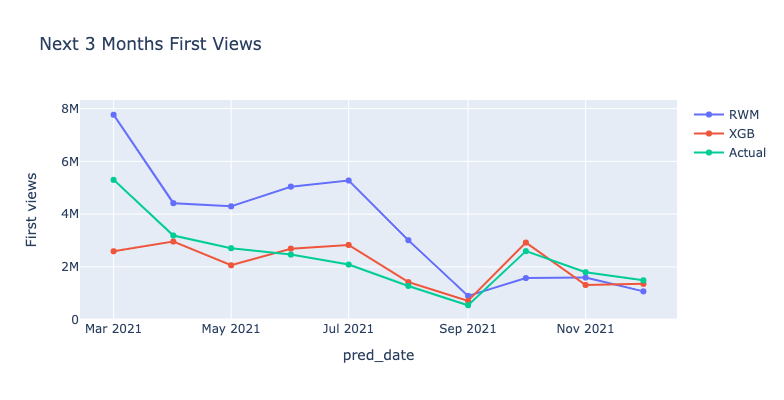

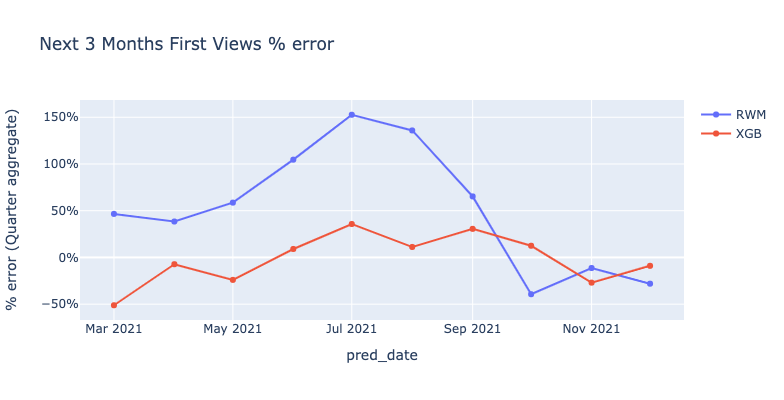

pct_error_first_views_pred_decay    21.748683
dtype: float64

pct_error_first_views_rwm    68.096403
dtype: float64

In [104]:
### Adhoc 

file_path = f's3://hbo-ingest-datascience-content-dev/psi_first_views/old_xgb_backtest.csv'
df_bt = pd.read_csv(file_path)
df_bt = df_bt.rename(columns={'first_views_decay_median_mx':'first_views_rwm','first_views_decay_dev_b':'first_views_pred_decay',
                             'pct_error_first_views_decay_median_mx':'pct_error_first_views_rwm', 'pct_error_first_views_decay_dev_b':'pct_error_first_views_pred_decay'})

### Plot error 
## Month 
list_postfix = ['pred_decay','rwm',]
grpby=[agg_var, 'title_name', 'season_number']
df_grp=evaluate_pred_plt(df_eval, grpby, [f'first_views_{i}' for i in list_postfix])

df_grp = pd.concat([df_bt, df_grp[df_grp.pred_date>='2021-10-01']])
get_pred_plot(df_grp, agg_var,'Next 3 Months First Views')
get_pct_error_plot(df_grp, agg_var, 'Next 3 Months First Views % error')
display(df_grp[['pct_error_first_views_pred_decay']].abs().mean())
display(df_grp[['pct_error_first_views_rwm']].abs().mean())

In [2]:
### Publish to output table 


def cvdf_to_snowflake(df, table_name):
    stage = '@HBO_OUTBOUND_DATASCIENCE_CONTENT_DEV'
    output_bucket = "hbo-outbound-datascience-content-dev"
    filename ='psi/' + table_name + '.csv'
    dbname, schema = 'MAX_DEV', 'WORKSPACE'
    
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index = False)
    content = csv_buffer.getvalue()
    client = boto3.client('s3')
    client.put_object(Bucket=output_bucket, Key=filename, Body=content)

    print ('Create Table: ' + table_name)
    run_query('''
    create or replace table {table_name}(
    title_name varchar,
    season_number int, 
    content_category  varchar,
    category varchar,
    tier varchar,
    premiere_date varchar,
    first_view_month varchar,
    prequel_count int,
    prequel_featured_count int,
    tier_adjusted int,
    first_views_pred float,
    model_train_date varchar
    )
    '''.format(table_name = table_name), dbname, schema)

    print ('Begin Uploading')
    run_query('''
    insert into max_dev.content_analytics.{table_name}

    select 
          $1, $2, $3, $4, $5, $6, $7, $8, $9, $10, $11, $12
    from {stage}/psi/{file_name}

     (FILE_FORMAT => csv_v2)

    '''.format(stage = stage, table_name = table_name,
              file_name = table_name+'.csv')
            , dbname, schema)

    print ('Finish Uploading')    


def run_query(query, dbname, schema):
    SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

    conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
    ctx=conn.connect(dbname,schema)
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df


# dic_rename = {'tier_adj':'tier_adjusted', 'effective_start_date':'premiere_date', 
#              'first_views_xgb':'first_views_pred'}

# out_col = ['title_name',  'season_number','content_category', 'category',
#            'tier', 'premiere_date','first_view_month', 
#            'prequel_count', 'prequel_featured_count', 'tier_adjusted', 'first_views_pred', 'model_train_date']

# df_pred_future_out = df_pred_future_fv_xgb.rename(columns=dic_rename)
# df_pred_future_out['model_train_date']='2021-12-01'
# df_pred_future_out = df_pred_future_out[out_col]


# ## QA 
# display(df_pred_future_out.head())
# a = df_pred_future_out.groupby(by=['title_name','category','tier','premiere_date']).sum().reset_index()
# a[a.category=='Pay 1 WB Theatricals']

# print(a.premiere_date.min(),a.premiere_date.max()) 
# print(a.shape, a.title_name.nunique())

## Upload to snowflake 

# import io
## df_pred_future_out.to_csv('s3://hbo-ingest-datascience-content-dev/psi_first_views/future_program_xgb_pred.csv')
# Utils.to_csv_s3('future_program_xgb_pred.csv')
# cvdf_to_snowflake(df_pred_future_out, 'psi_daily_xgb_forecast')




In [14]:
df_pred_future_out.columns

Index(['Unnamed: 0', 'title_name', 'season_number', 'content_category',
       'category', 'tier', 'premiere_date', 'first_view_month',
       'prequel_count', 'prequel_featured_count', 'tier_adjusted',
       'first_views_pred', 'model_train_date'],
      dtype='object')

In [3]:
import io
import snowflake
df = pd.read_csv('s3://hbo-ingest-datascience-content-dev/psi_first_views/future_program_xgb_pred.csv')

out_col = ['title_name',  'season_number','content_category', 'category',
           'tier', 'premiere_date','first_view_month', 
           'prequel_count', 'prequel_featured_count', 'tier_adjusted', 'first_views_pred', 'model_train_date']
df_pred_future_out = df[df.premiere_date>='2022-01-01'][out_col]
cvdf_to_snowflake(df_pred_future_out, 'psi_daily_xgb_forecast')

INFO:charset_normalizer:ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
INFO:charset_normalizer:ascii should target any language(s) of ['Latin Based']
INFO:charset_normalizer:We detected language [('Indonesian', 0.95), ('Simple English', 0.9), ('English', 0.85)] using ascii
INFO:charset_normalizer:ascii is most likely the one. Stopping the process.
INFO:charset_normalizer:ascii passed initial chaos probing. Mean measured chaos is 0.000000 %
INFO:charset_normalizer:ascii should target any language(s) of ['Latin Based']
INFO:charset_normalizer:We detected language [('German', 0.8333), ('Hungarian', 0.8333), ('Slovak', 0.8333), ('English', 0.75), ('Dutch', 0.75), ('Italian', 0.75), ('Swedish', 0.75), ('Norwegian', 0.75), ('Czech', 0.75), ('Indonesian', 0.75), ('Danish', 0.75), ('Polish', 0.6667), ('Finnish', 0.6667), ('Slovene', 0.6667), ('Turkish', 0.5833), ('Vietnamese', 0.5), ('Lithuanian', 0.5)] using ascii
INFO:charset_normalizer:ascii is most likely the one. St

Create Table: psi_daily_xgb_forecast


INFO:snowflake.connector.cursor:query: [create or replace table psi_daily_xgb_forecast( title_name varchar, season_numbe...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.connection:Snowflake Connector for Python Version: 2.7.3, Python Version: 3.6.13, Platform: Linux-4.14.252-131.483.amzn1.x86_64-x86_64-with-glibc2.9
INFO:snowflake.connector.connection:This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.


Begin Uploading


INFO:snowflake.connector.cursor:query: [insert into max_dev.content_analytics.psi_daily_xgb_forecast  select $1, $2, $3,...]
INFO:snowflake.connector.cursor:query execution done
INFO:snowflake.connector.connection:closed
INFO:snowflake.connector.connection:No async queries seem to be running, deleting session


ProgrammingError: 002003 (02000): 01a1d953-0604-0cef-00f8-4101b1dd37bb: SQL compilation error:
Schema 'MAX_DEV.CONTENT_ANALYTICS' does not exist or not authorized.

In [39]:
df_pred_future_out[(df_pred_future_out.tier==0)].sort_values(by=['first_view_month','title_name',])

,title_name,season_number,content_category,category,tier,premiere_date,first_view_month,prequel_count,prequel_featured_count,tier_adjusted,first_views_pred,model_train_date
111,And Just Like That,1,0,Scripted Comedy Series,0,2021-12-09,2021-12-01,-1.0,-1.0,0,253808.719145,2021-12-01
112,And Just Like That,1,0,Scripted Comedy Series,0,2021-12-09,2022-01-01,-1.0,-1.0,0,86880.104662,2021-12-01
113,And Just Like That,1,0,Scripted Comedy Series,0,2021-12-09,2022-02-01,-1.0,-1.0,0,31193.938493,2021-12-01
114,And Just Like That,1,0,Scripted Comedy Series,0,2021-12-09,2022-03-01,-1.0,-1.0,0,7240.331449,2021-12-01
2412,The Flight Attendant,2,0,Scripted Drama Series,0,2022-04-21,2022-04-01,-1.0,-1.0,0,83252.651612,2021-12-01
2413,The Flight Attendant,2,0,Scripted Drama Series,0,2022-04-21,2022-05-01,-1.0,-1.0,0,222852.218733,2021-12-01
2414,The Flight Attendant,2,0,Scripted Drama Series,0,2022-04-21,2022-06-01,-1.0,-1.0,0,81856.223577,2021-12-01
2415,The Flight Attendant,2,0,Scripted Drama Series,0,2022-04-21,2022-07-01,-1.0,-1.0,0,25201.968578,2021-12-01
1233,House Of The Dragon,1,0,Scripted Drama Series,0,2022-08-21,2022-08-01,-1.0,-1.0,0,87933.946910,2021-12-01
1234,House Of The Dragon,1,0,Scripted Drama Series,0,2022-08-21,2022-09-01,-1.0,-1.0,0,218170.923435,2021-12-01


In [99]:
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Pay 1 WB Theatricals') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index())
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Pay 1 WB Theatricals') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index())

print('Pay1')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Pay 1') & (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Pay 1') & (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))


print('tier 1')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Tier 1') & (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Tier 1') & (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))

print('tier 2')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Tier 2') & (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Tier 2') & (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))

print('tier 1+')
grpby = ['title_name','tier_cat','season_number','category','first_view_quarter','model']
display(df_pred_future_fv_xgb[(df_pred_future_fv_xgb.tier_cat=='Tier 1+')& (df_pred_future_fv_xgb.first_view_quarter>='2022Q3') & (df_pred_future_fv_xgb.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))
display(df_pred_future_fv_rwm[(df_pred_future_fv_rwm.tier_cat=='Tier 1+')& (df_pred_future_fv_rwm.first_view_quarter>='2022Q3') & (df_pred_future_fv_rwm.first_view_quarter<='2022Q4')].groupby(by=grpby).sum().reset_index().sort_values(by=['first_view_quarter','first_views']))


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
0,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,223481.865608
1,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,227930.228142
2,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,359667.070868
3,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,1951.616632
4,Don't Worry Darling,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,156899.836317
5,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,155255.794491
6,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,26398.971134
7,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q2,xgb,274002.504684
8,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,xgb,128494.214066
9,Salem's Lot,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,xgb,168683.131404


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
0,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,653487.0
1,Black Adam,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,291353.0
2,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,61298.0
3,DC League Of Super-Pets,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,112.0
4,Don't Worry Darling,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,56757.0
5,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,56633.0
6,Elvis,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,4777.0
7,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q2,rwm,50786.0
8,Fantastic Beasts: The Secrets of Dumbledore,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q3,rwm,10624.0
9,Salem's Lot,Pay 1 WB Theatricals,0,Pay 1 WB Theatricals,2022Q4,rwm,58871.0


Pay1


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
12,The Night House,Pay 1,0,Pay1,2022Q3,xgb,792.270747
10,Old,Pay 1,0,Pay1,2022Q3,xgb,4197.720050
4,Dear Evan Hansen,Pay 1,0,Pay1,2022Q3,xgb,5420.098321
7,Last Night in Soho,Pay 1,0,Pay1,2022Q3,xgb,15447.038893
11,The Card Counter,Pay 1,0,Pay1,2022Q3,xgb,25208.782787
8,Moonfall,Pay 1,0,Pay1,2022Q3,xgb,27538.233381
0,Belfast,Pay 1,0,Pay1,2022Q3,xgb,30755.317478
13,Wolf,Pay 1,0,Pay1,2022Q3,xgb,37449.597417
2,Blue Bayou,Pay 1,0,Pay1,2022Q3,xgb,38569.898184
3,Blue Bayou,Pay 1,0,Pay1,2022Q4,xgb,3930.574472


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
12,The Night House,Pay 1,0,Pay1,2022Q3,rwm,245.0
10,Old,Pay 1,0,Pay1,2022Q3,rwm,3028.0
4,Dear Evan Hansen,Pay 1,0,Pay1,2022Q3,rwm,4037.0
0,Belfast,Pay 1,0,Pay1,2022Q3,rwm,9699.0
7,Last Night in Soho,Pay 1,0,Pay1,2022Q3,rwm,11241.0
13,Wolf,Pay 1,0,Pay1,2022Q3,rwm,11567.0
2,Blue Bayou,Pay 1,0,Pay1,2022Q3,rwm,11990.0
11,The Card Counter,Pay 1,0,Pay1,2022Q3,rwm,18110.0
8,Moonfall,Pay 1,0,Pay1,2022Q3,rwm,21429.0
3,Blue Bayou,Pay 1,0,Pay1,2022Q4,rwm,1150.0


tier 1


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
9,The Staircase,Tier 1,1,Scripted Drama Series,2022Q3,xgb,24331.653864
6,Pretty Little Liars: Original Sin,Tier 1,1,Scripted Drama Series,2022Q3,xgb,139238.591108
2,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q3,xgb,143747.558326
10,Titans,Tier 1,4,Scripted Drama Series,2022Q3,xgb,159669.749193
12,Westworld,Tier 1,4,Scripted Drama Series,2022Q3,xgb,170670.017357
3,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q4,xgb,4768.332299
7,Quizzarding World,Tier 1,2,Kids & Family,2022Q4,xgb,20699.392555
11,Titans,Tier 1,4,Scripted Drama Series,2022Q4,xgb,32707.469557
0,And Just Like That,Tier 1,2,Scripted Comedy Series,2022Q4,xgb,100758.361400
1,Batgirl (DC),Tier 1,0,Scripted Features,2022Q4,xgb,119891.672462


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
9,The Staircase,Tier 1,1,Scripted Drama Series,2022Q3,rwm,24868.0
6,Pretty Little Liars: Original Sin,Tier 1,1,Scripted Drama Series,2022Q3,rwm,116834.0
10,Titans,Tier 1,4,Scripted Drama Series,2022Q3,rwm,132677.0
12,Westworld,Tier 1,4,Scripted Drama Series,2022Q3,rwm,145120.0
2,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q3,rwm,912313.0
7,Quizzarding World,Tier 1,2,Kids & Family,2022Q4,rwm,14060.0
11,Titans,Tier 1,4,Scripted Drama Series,2022Q4,rwm,32375.0
3,Father of the Bride Latinx,Tier 1,0,Scripted Features,2022Q4,rwm,32527.0
4,Gossip Girl,Tier 1,2,Scripted Drama Series,2022Q4,rwm,134009.0
5,Love & Death,Tier 1,1,Scripted Drama Series,2022Q4,rwm,154771.0


tier 2


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
35,Roadrunner: A Film About Anthony Bourdain,Tier 2,0,Documentary Features,2022Q3,xgb,958.212435
45,TBD Feature A '22,Tier 2,0,Scripted Features,2022Q3,xgb,1132.291209
5,Close Enough,Tier 2,3,Scripted Comedy Series,2022Q3,xgb,1869.770209
27,Made for Love,Tier 2,2,Scripted Comedy Series,2022Q3,xgb,6781.559386
32,Phoenix Rising,Tier 2,0,Documentary Features,2022Q3,xgb,7656.577029
1,Barry,Tier 2,3,Scripted Comedy Series,2022Q3,xgb,8242.077174
47,The Baby,Tier 2,1,Scripted Comedy Series,2022Q3,xgb,8242.077174
24,Looney Tunes,Tier 2,5,Kids & Family,2022Q3,xgb,10981.580839
11,George Carlin,Tier 2,0,Documentary Features,2022Q3,xgb,12988.397666
20,Legendary,Tier 2,3,Unscripted Series,2022Q3,xgb,13033.173818


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
29,Made for Love,Tier 2,2,Scripted Comedy Series,2022Q3,rwm,408.0
37,Roadrunner: A Film About Anthony Bourdain,Tier 2,0,Documentary Features,2022Q3,rwm,444.0
5,Close Enough,Tier 2,3,Scripted Comedy Series,2022Q3,rwm,445.0
47,TBD Feature A '22,Tier 2,0,Scripted Features,2022Q3,rwm,470.0
22,Legendary,Tier 2,3,Unscripted Series,2022Q3,rwm,608.0
26,Looney Tunes,Tier 2,5,Kids & Family,2022Q3,rwm,979.0
2,Batwheels,Tier 2,1,Kids & Family,2022Q3,rwm,1510.0
1,Barry,Tier 2,3,Scripted Comedy Series,2022Q3,rwm,1953.0
49,The Baby,Tier 2,1,Scripted Comedy Series,2022Q3,rwm,1953.0
34,Phoenix Rising,Tier 2,0,Documentary Features,2022Q3,rwm,3167.0


tier 1+


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
2,The Flight Attendant,Tier 1+,2,Scripted Drama Series,2022Q3,xgb,23359.882018
0,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q3,xgb,283730.758339
1,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q4,xgb,99232.991661


,title_name,tier_cat,season_number,category,first_view_quarter,model,first_views
2,The Flight Attendant,Tier 1+,2,Scripted Drama Series,2022Q3,rwm,11769.0
0,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q3,rwm,803035.0
1,House Of The Dragon,Tier 1+,1,Scripted Drama Series,2022Q4,rwm,352320.0
